### Table of contents
[Predefined functions](#funcs)

[Parameters, filenames and directories](#params)

[Reading maps and catalogs](#read)

[Function for plotting statistics for different outlCoeff](#plotStatOutlCoeff)

[SpecZ outlier filtering](#specZ)

[PhotoZ_ML outlier filtering](#photoZ_ML)

[PhotoZ_SED outlier filtering](#photoZ_SED)

[ActivMap filtering](#activMap)

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from func_maps import readMaps
from func_stat import *
from func_visualizations import *
from os.path import join
from ast import literal_eval

### Parameters, filenames and directories
<a id='params'>#params</a>

In [2]:
### Files and directories ###
dirSOM=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\SOM\forArticle'
#dirSOM=r'/mnt/Data/Work/Sources/COSMOS/CatalogsFromWorkingPC'
nameOfExperiment='ex018'
dirMaps=join(dirSOM,nameOfExperiment,'maps')
dirPlots=join(dirSOM,nameOfExperiment,'plots')
dirDatasets=join(dirSOM,nameOfExperiment,'datasets')
mapsAllKeys=['mapsTrainOnTrain','mapsTestOnTrain','mapsDeimosOnTrain','mapsRunOnTrain',
             'mapsTrainOnRun','mapsTestOnRun','mapsDeimosOnRun','mapsRunOnRun',
             'mapsTrainOnRunBig','mapsTestOnRunBig','mapsDeimosOnRunBig','mapsRunOnRunBig']

In [3]:
datasetNames={'Train':r'05_COSMOS_SpectrZ_Zlim_1p2_SOMinfo.csv',
              'Test':r'05_COSMOS_SpectrZ_Zlim_1p2_Test_SOMinfo.csv',
              'Deimos':r'04_COSMOS_DEIMOS_QfFilter_SOMinfo.csv',
              'Run':r'04_COSMOS2015_run_WorkBands_SOMinfo.csv'}

In [4]:
idCol='Seq'
specZ='specZ'
photoZ_ML='photoZ_ML'
photoZ_SED='photoZ_SED'
residML='resid_ML'
residSED='resid_SED'
residML_SED='residML_SED'
quantErr='quantErr'

In [5]:
### Format for saving images ###
imSaveFormat='.png'
#imSaveFormat='.eps'

### Reading datasets
<a id='read'>#read</a>

In [6]:
datasets={}
cellIDs=['cellID_TrainSOM','cellID_RunSOM','cellID_RunBigSOM']
for key,val in datasetNames.items():
    datasets[key]=pd.read_csv(join(dirDatasets,val))
    for cellID in cellIDs:
        datasets[key][cellID]=[literal_eval(x) for x in datasets[key][cellID]]

### Calculating statistics
<a id='statDeclare'>#statDeclare</a>
<p>Since we have a bit too many statistical tables, they are stashed in one dictionary. It's structure is as follows:</p>
    <br>Dictionary statAll has keys which correspond to datasets.
    <br>For each key we have a dictionary which keys correspond to stat table names. We have: 
    <br>- 'basic' table, which corresponds to different cases of cleaning (None, SpecZ, PhotoZ, activMap and their combinations);
    <br>- 'magBin' table, which describes statistics within magnitude bins;
    <br>- 'oultCoeff' for specZ, SED and ML photoZ, which describe statistics within each bin of outlier coefficients;
    <br>- 'activMap' table, which describes statistics for different occupations of cells;
    <br>- probably something else.

In [7]:
statAll={name:{} for name in datasetNames.keys()}

In [8]:
### Calculate statistics for general cases: no filtering, specZ/photoZ/activMap filterings ###
for name in statAll.keys():
    if name=='Run':
        residCols=[residML_SED]
        colsFilt=[photoZ_ML+'_outlCoeff',photoZ_SED+'_outlCoeff']
    else:
        residCols=[residML,residSED,residML_SED]
        colsFilt=[specZ+'_outlCoeff',photoZ_ML+'_outlCoeff',photoZ_SED+'_outlCoeff']

    statAll[name]['Basic']=createStatTab(residCols,indexName='case')
    
    data=datasets[name]
    statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case='No filtering',data=data,
                                             residCols=residCols)
    data=datasets[name][datasets[name]['trainMapOccupation']>5]
    statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case='trainMapOccupation>5',data=data,
                                             residCols=residCols)
    for col in colsFilt:
        data=datasets[name][datasets[name][col].abs()<=1]
        statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case=col+'<=1',data=data,
                                             residCols=residCols)
        data=data[data['trainMapOccupation']>5]
        statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case=col+' + occupation filters',data=data,
                                             residCols=residCols)
    

In [9]:
for name in statAll.keys():
    colsFilt=[photoZ_ML+'_outlCoeff',photoZ_SED+'_outlCoeff']
    residCols=[residML,residSED,residML_SED]

    for col in colsFilt:
        if name=='Run':
            continue
        data=datasets[name][datasets[name][col].abs()<=1]
        data=data[data[specZ+'_outlCoeff'].abs()<=1]
        statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case=col+'<=1, '+'specZ_outlCoeff<=1',data=data,
                                             residCols=residCols)
        data=data[data['trainMapOccupation']>5]
        statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case=col+'+ specZ + occupation filters',data=data,
                                             residCols=residCols)

In [10]:
### Calculate statistics by magnitude bins ###
numBins=40
bins=np.linspace(16, 28, numBins)
for name in statAll.keys():
    if name=='Run':
        residCols=[residML_SED]
    else:
        residCols=[residML,residSED,residML_SED]
    statAll[name]['magBins']=statByBins(datasets[name],binCol='ipmagap3',residCols=residCols,bins=bins)

In [11]:
### Calculate statistics for objects with different outlCoeff ###
cases=[specZ,photoZ_ML,photoZ_SED]
residCols=[residML,residSED,residML_SED]
bins=np.arange(-5, 5.5,step=0.5)
for name in statAll.keys():
    for c in cases:
        if name=='Run':
            if c==specZ:
                continue
            else:
                statAll[name]['outlCoeff_'+c]=statByBins(datasets[name],binCol=c+'_outlCoeff',residCols=[residML_SED],bins=bins)
        else:
            statAll[name]['outlCoeff_'+c]=statByBins(datasets[name],binCol=c+'_outlCoeff',residCols=residCols,bins=bins)

In [12]:
### Calculate statistics for objects from cells with different occupation by objects from train dataset ###
residCols=[residML,residSED,residML_SED]
bins=sorted(datasets['Train']['trainMapOccupation'].unique())
for name in statAll.keys():
    if name=='Run':
        residCols=[residML_SED]
    else:
        residCols=[residML,residSED,residML_SED]

    statAll[name]['activMap']=createStatTab(residCols,addCols=['trainMapOccupation'])
    for b in bins:
        data=datasets[name][datasets[name]['trainMapOccupation']==b]
        if len(data)>0:
            statAll[name]['activMap']=allStatsAddRec(statAll[name]['activMap'],case=b,data=data,
                                             residCols=residCols,addCols={'trainMapOccupation':b})

In [13]:
### Calculate statistics by magnitude bins for different cleaning cases###
numBins=40
bins=np.linspace(16, 28, numBins)
for name in statAll.keys():
    if name=='Run':
        residCols=[residML_SED]
        data=datasets[name][datasets[name][photoZ_SED+'_outlCoeff'].abs()<=1]
        statAll[name]['magBins_photoZ_SED_filt']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name]['trainMapOccupation']>5]
        statAll[name]['magBins_activMap']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name][photoZ_SED+'_outlCoeff'].abs()<=1]
        data=data[data['trainMapOccupation']>5]
        statAll[name]['magBins_activMap_photoZ_SED']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)
    else:
        residCols=[residML,residSED,residML_SED]
        data=datasets[name][datasets[name][specZ+'_outlCoeff'].abs()<=1]
        statAll[name]['magBins_specZ_filt']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name]['trainMapOccupation']>5]
        statAll[name]['magBins_activMap']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name][specZ+'_outlCoeff'].abs()<=1]
        data=data[data['trainMapOccupation']>5]
        statAll[name]['magBins_activMap_specZ']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)

In [14]:
### Calculate statistics by spec-z bins for different cleaning cases###
numBins=7
bins=np.linspace(0, 1.2, numBins)
for name in statAll.keys():
    if name!='Run':
        residCols=[residML,residSED,residML_SED]
        statAll[name]['specZBins']=statByBins(datasets[name],binCol='specZ',residCols=residCols,bins=bins)
        
        data=datasets[name][datasets[name][specZ+'_outlCoeff'].abs()<=1]
        statAll[name]['specZBins_specZ_filt']=statByBins(data,binCol='specZ',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name]['trainMapOccupation']>5]
        statAll[name]['specZBins_activMap']=statByBins(data,binCol='specZ',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name][specZ+'_outlCoeff'].abs()<=1]
        data=data[data['trainMapOccupation']>5]
        statAll[name]['specZBins_activMap_specZ']=statByBins(data,binCol='specZ',residCols=residCols,bins=bins)

### Function for plotting statistics for different outlCoeff
<a id='plotStatOutlCoeff'>#plotStatOutlCoeff</a>

In [15]:
def plotStatsForOutlCoeff(data,case,stats,datasetNames,lims=(-3,3)):
    fig,axs=plt.subplots(6,len(data),figsize=(7*len(data),15),sharey='row',sharex='col')
    if len(data)==1:
        axs=[[ax] for ax in axs]
    estimators=['Std','NMAD','Mean','% outl_15']
    c=case
    i=0
    for j,d in enumerate(data):
        axs[i][j].set_xlim(lims)
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residML],s=5,label='ML')
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residSED],s=5,label='SED',alpha=0.7)
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('resid')

    i=1
    for j,s in enumerate(stats):
        axs[i][j].set_xlim(lims)
        axs[i][j].plot(s['outlCoeff_'+c]['General']['binEdge'],s['outlCoeff_'+c]['General']['Num objects'],
                       markersize=10,label='Number of objects',marker='o')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].grid(axis='y',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('Num objects')

    ii=2
    for i,est in enumerate(estimators):
        for j,s in enumerate(stats):
            axs[i+ii][j].grid(axis='y',linestyle ='--')
            axs[i+ii][j].grid(axis='x',linestyle ='--')
            s=s['outlCoeff_'+c][(s['outlCoeff_'+c]['General']['binEdge']>=lims[0]) & (s['outlCoeff_'+c]['General']['binEdge']<=lims[1])]
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residML][est],markersize=10,label='ML',marker='o')
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residSED][est],markersize=10,label='SED',marker='x')
            axs[i+ii][j].set_xlim(lims)
            axs[i+ii][j].legend()
        axs[i+ii][0].set_ylabel(est)
    axs[-1][0].set_xlabel(c+' outlCoeff\n'+ datasetNames[0]+' dataset')
    if len(data)>1:
        axs[-1][1].set_xlabel(c+' outlCoeff\n'+ datasetNames[1]+' dataset')
    plt.tight_layout()
    return fig,axs

### SpecZ outlier filtering
<a id='specZ'>#specZ</a>

Text(0.5, 113.99999999999989, '$K_\\mathrm{SED}$\nTest dataset')

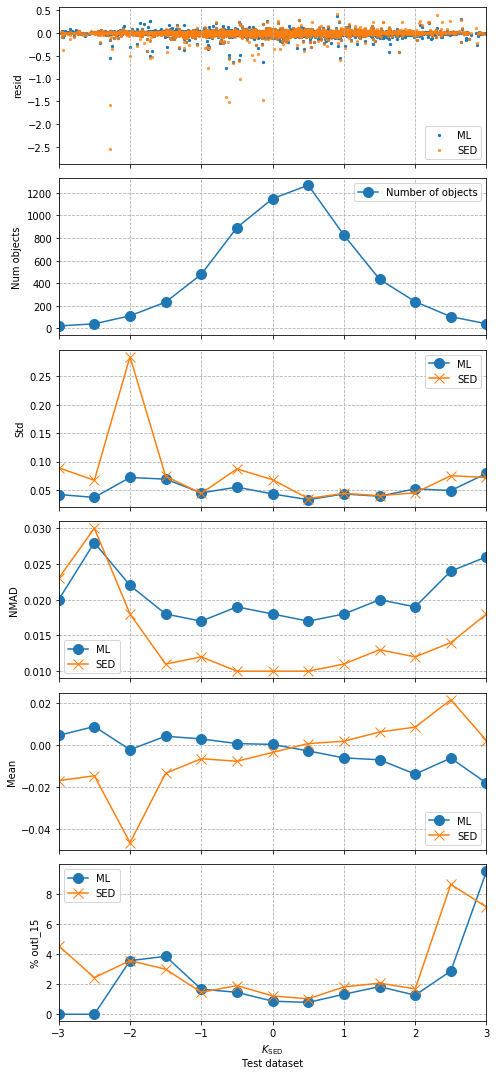

In [16]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=photoZ_SED
fig,axs=plotStatsForOutlCoeff(data,case,stats,datasetNamesPlot)
axs[-1][0].set_xlabel(r'$K_\mathrm{SED}$'+'\n'+ datasetNamesPlot[0]+' dataset')

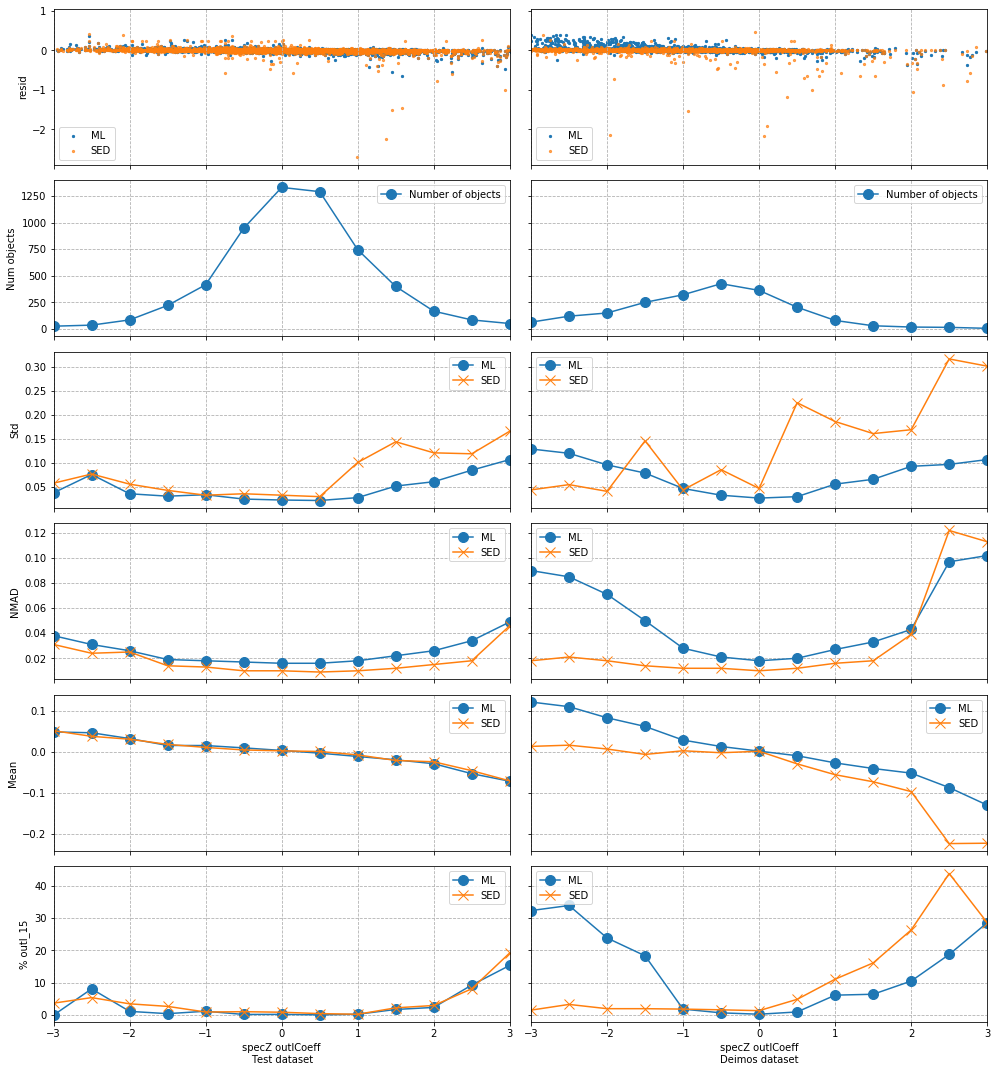

In [17]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=specZ
fig=plotStatsForOutlCoeff(data,case,stats,datasetNamesPlot)

### PhotoZ_ML outlier filtering
<a id='PhotoZ_ML'>#PhotoZ_ML</a>

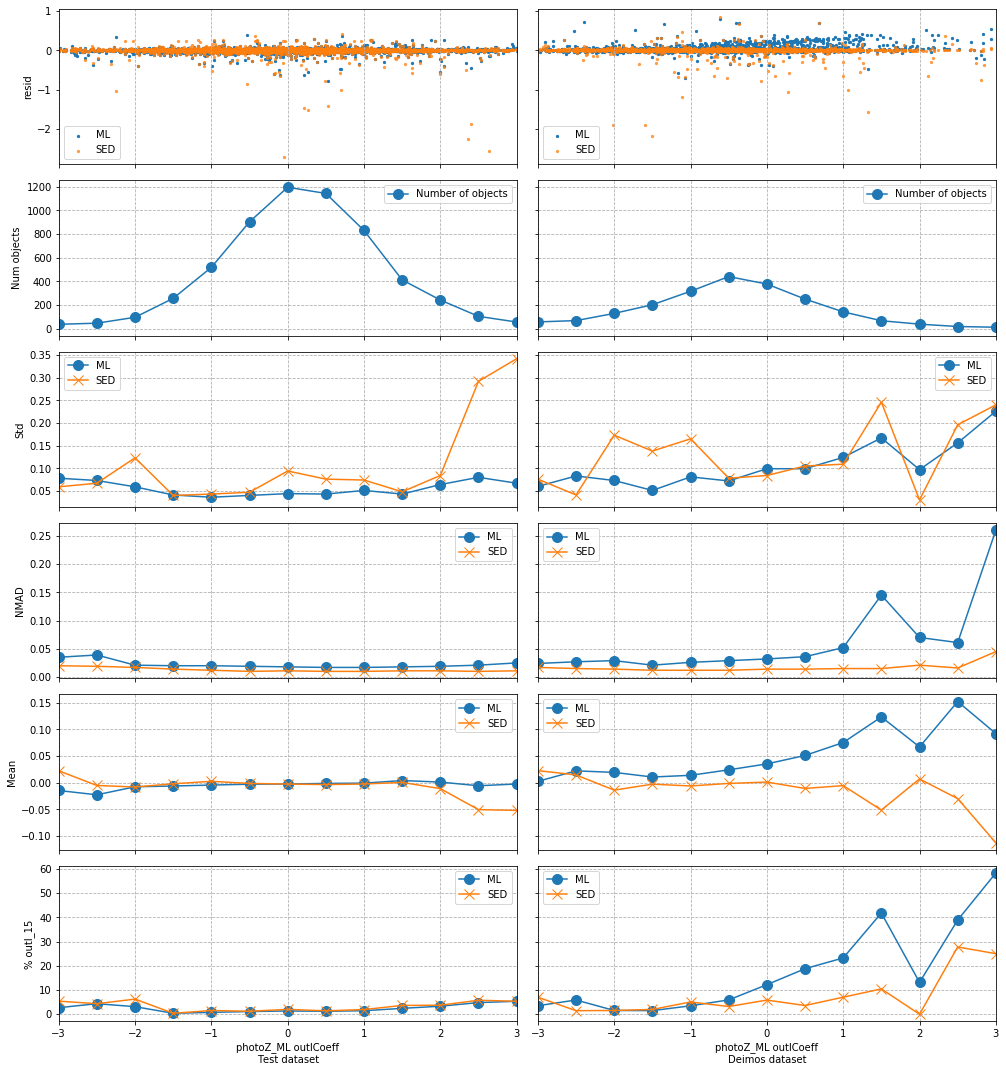

In [18]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=photoZ_ML
fig=plotStatsForOutlCoeff(data,case,stats,datasetNamesPlot)

### PhotoZ_SED outlier filtering
<a id='PhotoZ_SED'>#PhotoZ_SED</a>

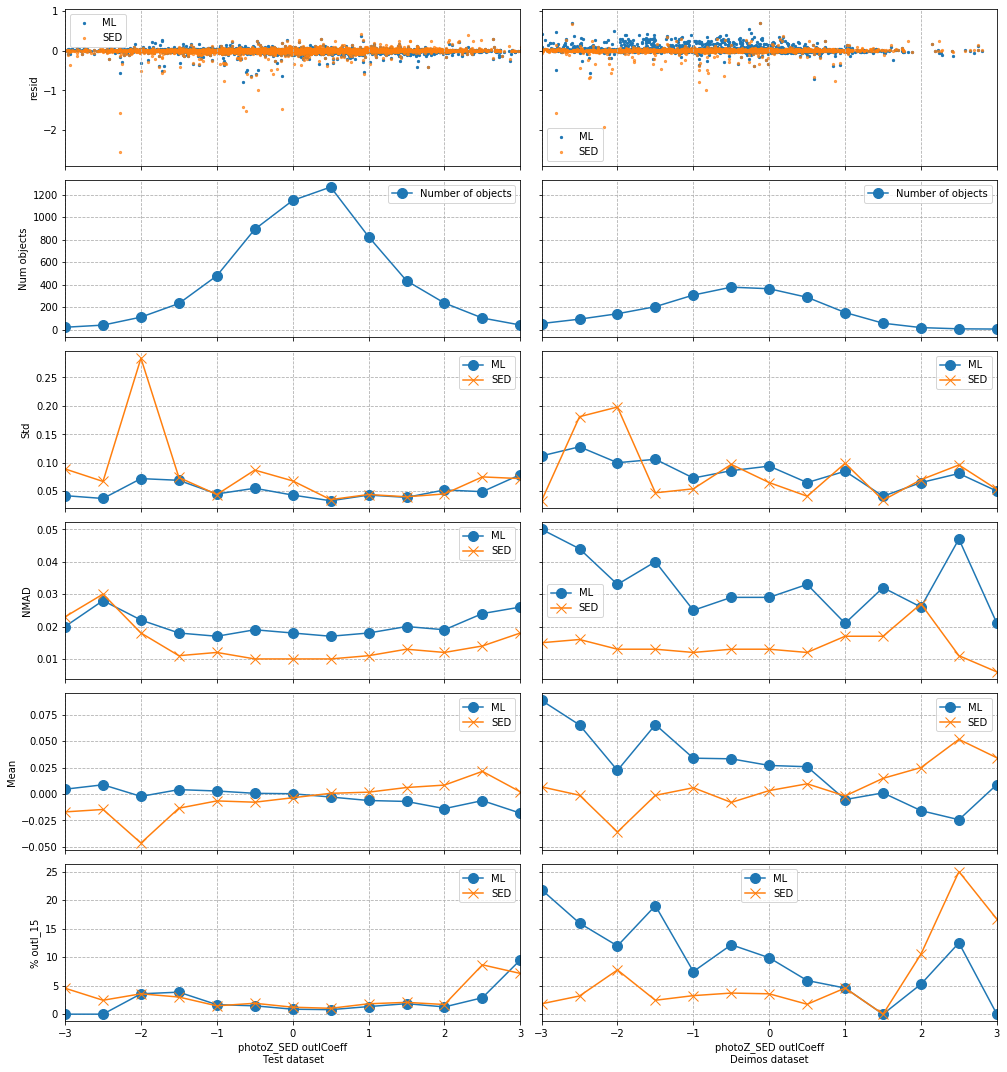

In [19]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=photoZ_SED
fig=plotStatsForOutlCoeff(data,case,stats,datasetNamesPlot)

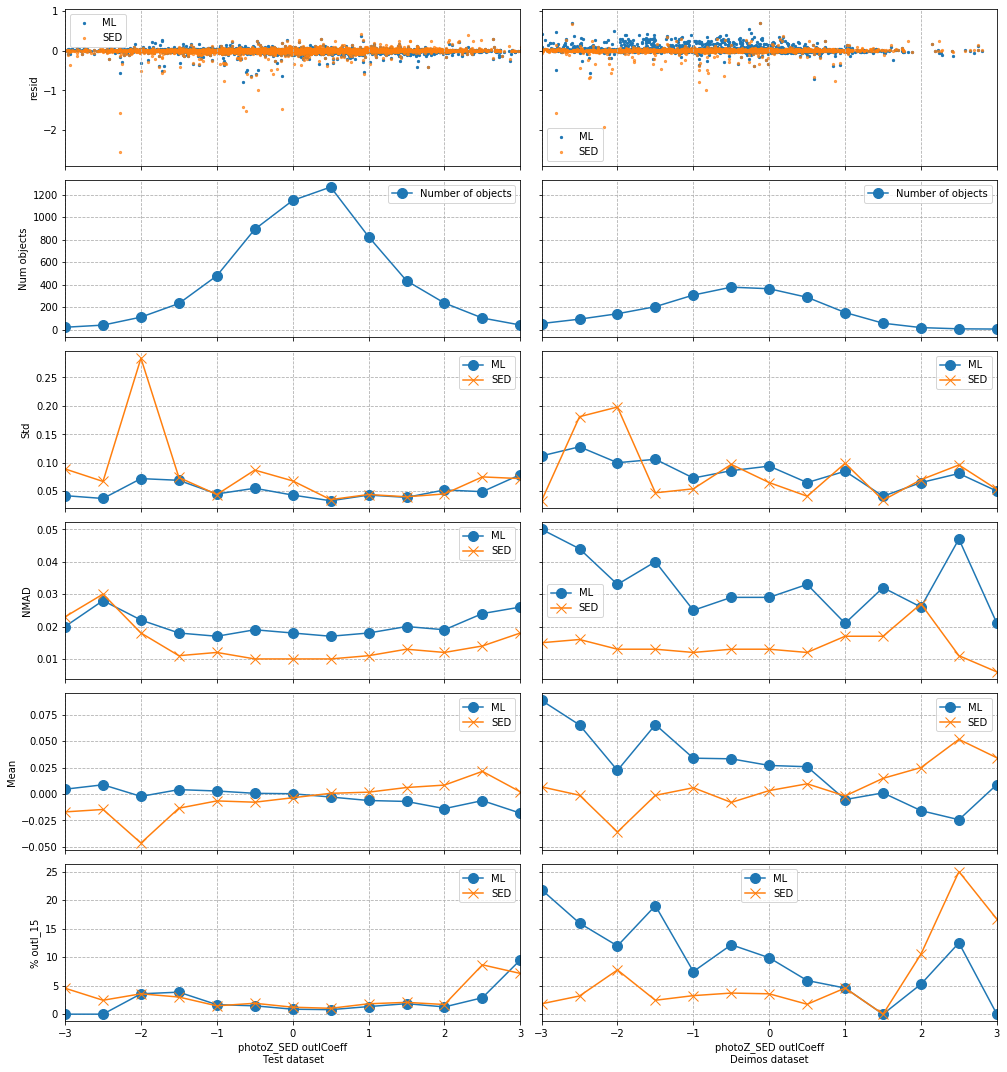

In [20]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=photoZ_SED
fig=plotStatsForOutlCoeff(data,case,stats,datasetNamesPlot)

In [21]:
def plotStatsForOutlCoeff2(data,case,stats,datasetNames,lims=(-3,3)):
    fig,axs=plt.subplots(6,len(data),figsize=(4*len(data),13),sharey='row',sharex='col')
    if len(data)==1:
        axs=[[ax] for ax in axs]
    estimators=['Std','NMAD','Mean','% outl_15']
    i=0
    textSize=12
    for j,d in enumerate(data):
        c=case[j]
        axs[i][j].set_xlim(lims)
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residML],s=5,label='ML')
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residSED],s=5,label='SED',alpha=0.7)
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('resid',size=textSize)

    i=1
    for j,s in enumerate(stats):
        c=case[j]
        axs[i][j].set_xlim(lims)
        axs[i][j].plot(s['outlCoeff_'+c]['General']['binEdge'],s['outlCoeff_'+c]['General']['Num objects'],
                       markersize=10,label='Number of objects',marker='o')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].grid(axis='y',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('Num objects',size=textSize)

    ii=2
    for i,est in enumerate(estimators):
        for j,s in enumerate(stats):
            c=case[j]
            if est=='Mean':
                axs[i+ii][j].axhline(0,color='black',ls='--',lw=0.5)
            axs[i+ii][j].grid(axis='y',linestyle ='--')
            axs[i+ii][j].grid(axis='x',linestyle ='--')
            s=s['outlCoeff_'+c][(s['outlCoeff_'+c]['General']['binEdge']>=lims[0]) & (s['outlCoeff_'+c]['General']['binEdge']<=lims[1])]
            s=s.mask(s['General']['Num objects']<=15)
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residML][est],markersize=10,label='ML',marker='o')
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residSED][est],markersize=10,label='SED',marker='x')
            axs[i+ii][j].set_xlim(lims)
            axs[i+ii][j].legend()
        axs[i+ii][0].set_ylabel(est,size=textSize)
    for j in range(len(datasetNames)):
        axs[-1][j].set_xlabel(case[j]+' outlCoeff\n'+ datasetNames[j]+' dataset',size=textSize)
    plt.tight_layout()
    return fig

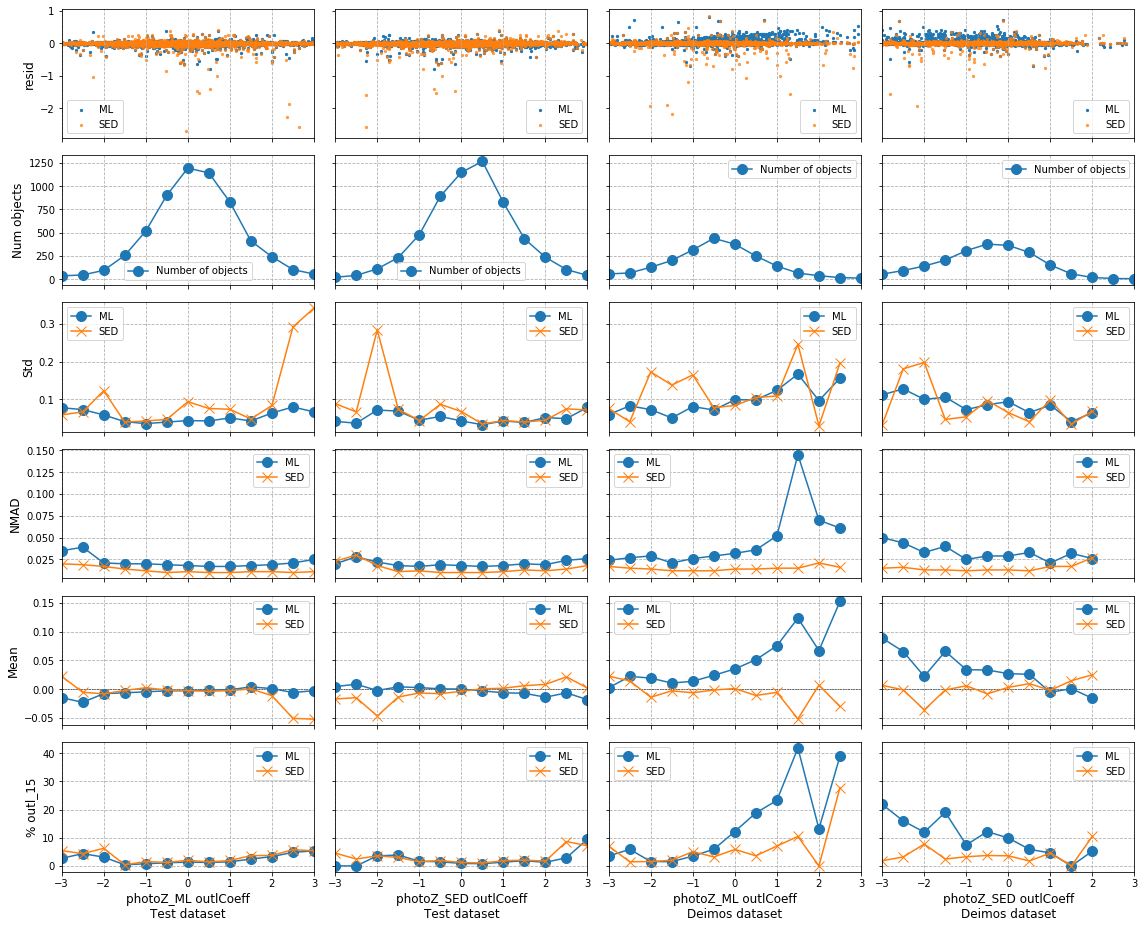

In [22]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Test','Deimos','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=[photoZ_ML,photoZ_SED,photoZ_ML,photoZ_SED,]
fig=plotStatsForOutlCoeff2(data,case,stats,datasetNamesPlot)

In [23]:
### Median/mean comparison in K_spec bins
data=datasets['Train']

In [32]:
for i in range(-3,4):
    print('i=',i)
    d=data[(data['specZ_outlCoeff']>i) & (data['specZ_outlCoeff']<i+1)]
    print('ML')
    r='resid_ML'
    print('mean',around(d[r].mean(),3))
    print('median',around(d[r].median(),3))
    print('mean/median',around(d[r].mean()/d[r].median(),3))
    print('SED')
    r='resid_SED'
    print('mean',around(d[r].mean(),3))
    print('median',around(d[r].median(),3))
    print('mean/median',around(d[r].mean()/d[r].median(),3))

i= -3
ML
mean 0.054
median 0.031
mean/median 1.742
SED
mean 0.055
median 0.021
mean/median 2.619
i= -2
ML
mean 0.018
median 0.014
mean/median 1.282
SED
mean 0.011
median 0.005
mean/median 2.071
i= -1
ML
mean 0.005
median 0.005
mean/median 0.993
SED
mean 0.002
median 0.002
mean/median 0.878
i= 0
ML
mean -0.006
median -0.003
mean/median 2.191
SED
mean -0.004
median 0.0
mean/median -8.297
i= 1
ML
mean -0.023
median -0.01
mean/median 2.251
SED
mean -0.032
median -0.003
mean/median 12.361
i= 2
ML
mean -0.089
median -0.054
mean/median 1.651
SED
mean -0.134
median -0.022
mean/median 6.149
i= 3
ML
mean -0.164
median -0.158
mean/median 1.04
SED
mean -0.228
median -0.171
mean/median 1.334


In [29]:
print('mean',data[(data['specZ_outlCoeff']>2) & (data['specZ_outlCoeff']<3)]['resid_SED'].mean())
print('median',data[(data['specZ_outlCoeff']>2) & (data['specZ_outlCoeff']<3)]['resid_SED'].median())

mean -0.13433892636599107
median -0.02184746213577355


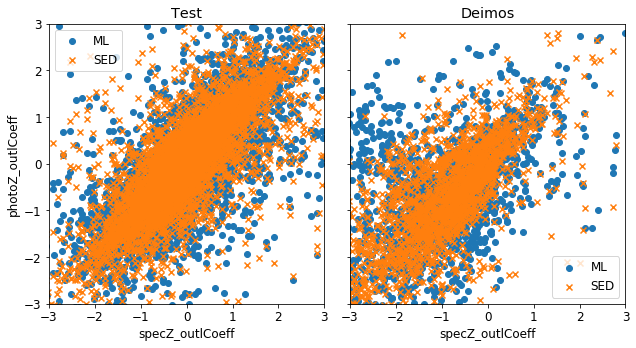

In [120]:
### Spec_z outl coeff vs Photo-z outl coeff ###
fig,axs=plt.subplots(1,2,figsize=(9,5),sharey='row',sharex='col')
datasetNames=['Test','Deimos']
for i,name in enumerate(datasetNames):
    axs[i].scatter(datasets[name][specZ+'_outlCoeff'],datasets[name][photoZ_ML+'_outlCoeff'],label='ML')
    axs[i].scatter(datasets[name][specZ+'_outlCoeff'],datasets[name][photoZ_SED+'_outlCoeff'],marker='x',label='SED')
    axs[i].set_xlabel('specZ_outlCoeff')
    
    axs[i].set_xlim((-3,3))
    axs[i].set_ylim((-3,3))
    axs[i].set_title(name)
    axs[i].legend()
axs[0].set_ylabel('photoZ_outlCoeff')
plt.tight_layout()

### ActivMap filtering
<a id='activMap'>#activMap</a>

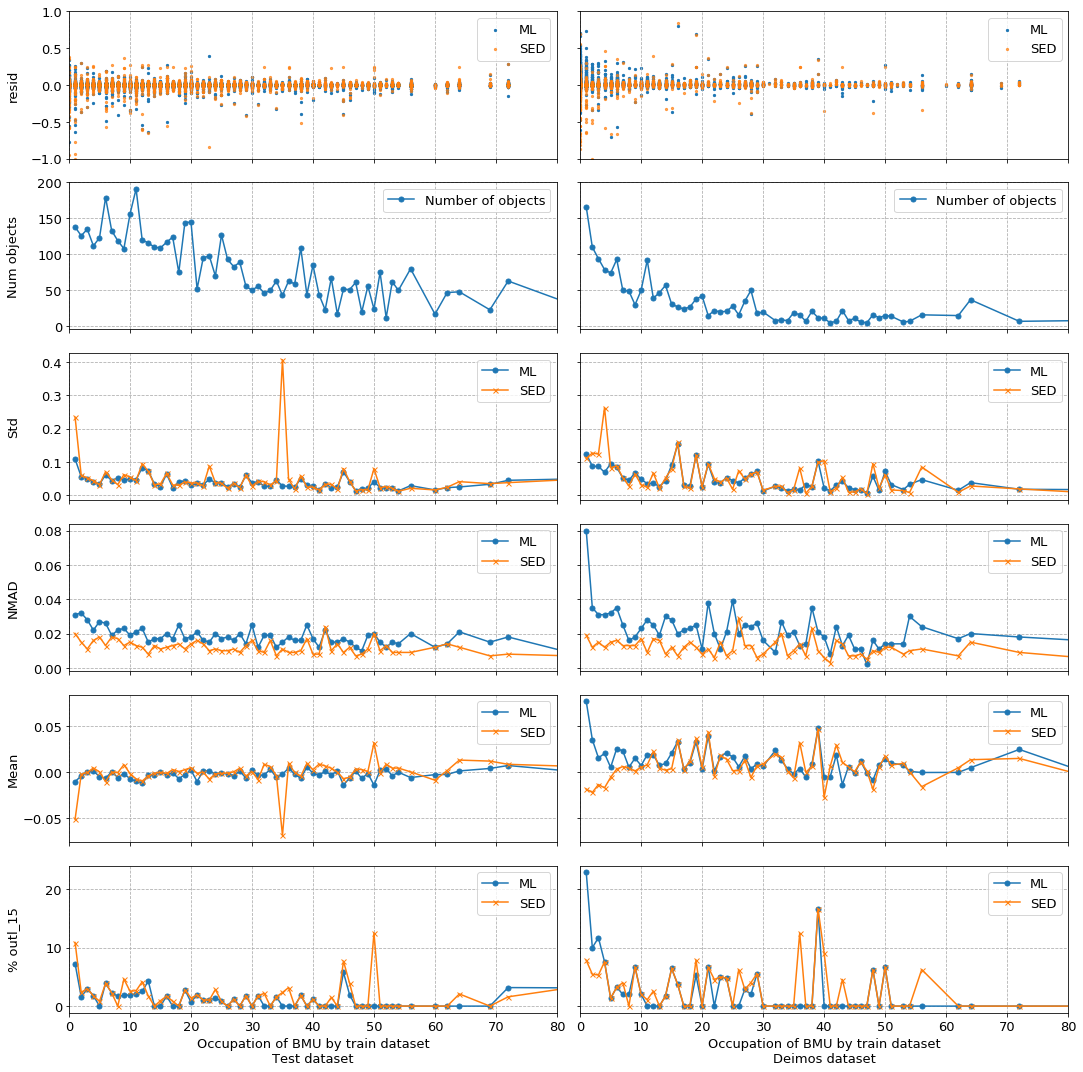

In [47]:
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
textSize=13

fig,axs=plt.subplots(6,2,figsize=(15,15),sharey='row',sharex='col')
estimators=['Std','NMAD','Mean','% outl_15']
i=0
for j,d in enumerate(data):
    axs[i][j].scatter(d['trainMapOccupation'],d[residML],s=5,label='ML')
    axs[i][j].scatter(d['trainMapOccupation'],d[residSED],s=5,label='SED',alpha=0.7)
    axs[i][j].grid(axis='x',linestyle ='--')
    axs[i][j].set_ylim(-1,1)
    axs[i][j].legend(fontsize=textSize)
    axs[i][0].set_ylabel('resid',size=textSize)
    axs[i][j].tick_params(axis='both', labelsize=textSize)
    axs[i][0].yaxis.set_label_coords(-0.1, 0.5)

i=1
for j,s in enumerate(stats):
    s=s['activMap'][s['activMap']['General']['Num objects']>=5]
    axs[i][j].plot(s['General']['trainMapOccupation'],s['General']['Num objects'],
                   markersize=5,label='Number of objects',marker='o')
    axs[i][j].grid(axis='x',linestyle ='--')
    axs[i][j].grid(axis='y',linestyle ='--')
    axs[i][j].legend(fontsize=textSize)
    axs[i][j].tick_params(axis='both', labelsize=textSize)
    axs[i][0].set_ylabel('Num objects',size=textSize)
    axs[i][0].yaxis.set_label_coords(-0.1, 0.5)

ii=2
for i,est in enumerate(estimators):
    for j,s in enumerate(stats):
        s=s['activMap'][s['activMap']['General']['Num objects']>=5]
        axs[i+ii][j].set_xlim(0,80)
        axs[i+ii][j].grid(axis='y',linestyle ='--')
        axs[i+ii][j].grid(axis='x',linestyle ='--')
        axs[i+ii][j].plot(s['General']['trainMapOccupation'],
                            s[residML][est],markersize=5,label='ML',marker='o')
        axs[i+ii][j].plot(s['General']['trainMapOccupation'],
                            s[residSED][est],markersize=5,label='SED',marker='x')
        axs[i+ii][j].legend(fontsize=textSize)
        axs[i+ii][j].tick_params(axis='both', labelsize=textSize)
    axs[i+ii][0].set_ylabel(est,size=textSize)
    axs[i+ii][0].yaxis.set_label_coords(-0.1, 0.5)
axs[-1][0].set_xlabel('Occupation of BMU by train dataset\n'+ datasetNamesPlot[0]+' dataset',size=textSize)
axs[-1][1].set_xlabel('Occupation of BMU by train dataset\n'+ datasetNamesPlot[1]+' dataset',size=textSize)
plt.tight_layout()

In [48]:
### Calculate statistics for objects with different outlCoeff after activMap cleaning###
cases=[specZ,photoZ_ML,photoZ_SED]
residCols=[residML,residSED,residML_SED]
bins=np.arange(-5, 5.5,step=0.5)
for name in statAll.keys():
    d=datasets[name]
    d=d[d['trainMapOccupation']>5]
    for c in cases:
        if name=='Run':
            if c==specZ:
                continue
            else:
                statAll[name]['outlCoeff_'+c+'_activMapClean']=statByBins(d,binCol=c+'_outlCoeff',residCols=[residML_SED],bins=bins)
        else:
            statAll[name]['outlCoeff_'+c+'_activMapClean']=statByBins(d,binCol=c+'_outlCoeff',residCols=residCols,bins=bins)

In [123]:
def plotStatsForOutlCoeff3(data,case,stats,datasetNames,lims=(-3,3),activMap=False):
    fig,axs=plt.subplots(6,len(data),figsize=(4*len(data),13),sharey='row',sharex='col')
    if len(data)==1:
        axs=[[ax] for ax in axs]
    estimators=['Std','NMAD','Mean','% outl_15']
    i=0
    textSize=12
    for j,d in enumerate(data):
        c=case[j]
        axs[i][j].set_xlim(lims)
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residML],s=5,label='ML')
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residSED],s=5,label='SED',alpha=0.7)
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('resid',size=textSize)
        axs[i][0].yaxis.set_label_coords(-0.1, 0.5)

    i=1
    for j,s in enumerate(stats):
        c=case[j]
        axs[i][j].set_xlim(lims)
        if activMap==True:
            k='outlCoeff_'+c+'_activMapClean'
        else:
            k='outlCoeff_'+c
        axs[i][j].plot(s[k]['General']['binEdge'],s[k]['General']['Num objects'],
                       markersize=10,label='Number of objects',marker='o')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].grid(axis='y',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('Num objects',size=textSize)
        axs[i][0].yaxis.set_label_coords(-0.1, 0.5)

    ii=2
    for i,est in enumerate(estimators):
        for j,s in enumerate(stats):
            c=case[j]
            axs[i+ii][j].grid(axis='y',linestyle ='--')
            axs[i+ii][j].grid(axis='x',linestyle ='--')
            if est=='Mean':
                axs[i+ii][j].axhline(0,color='black',ls='--',lw=0.5)
            if activMap==True:
                k='outlCoeff_'+c+'_activMapClean'
            else:
                k='outlCoeff_'+c
            s=s[k][(s[k]['General']['binEdge']>=lims[0]) & 
                                (s[k]['General']['binEdge']<=lims[1])]
            s=s.mask(s['General']['Num objects']<=15)
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residML][est],markersize=10,label='ML',marker='o')
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residSED][est],markersize=10,label='SED',marker='x')
            axs[i+ii][j].set_xlim(lims)
            axs[i+ii][j].legend()
            
        axs[i+ii][0].set_ylabel(est,size=textSize)
        axs[i+ii][0].yaxis.set_label_coords(-0.1, 0.5)
    for j in range(len(datasetNames)):
        axs[-1][j].set_xlabel(case[j]+' outlCoeff\n'+ datasetNames[j]+' dataset',size=textSize)
    plt.tight_layout()
    return fig

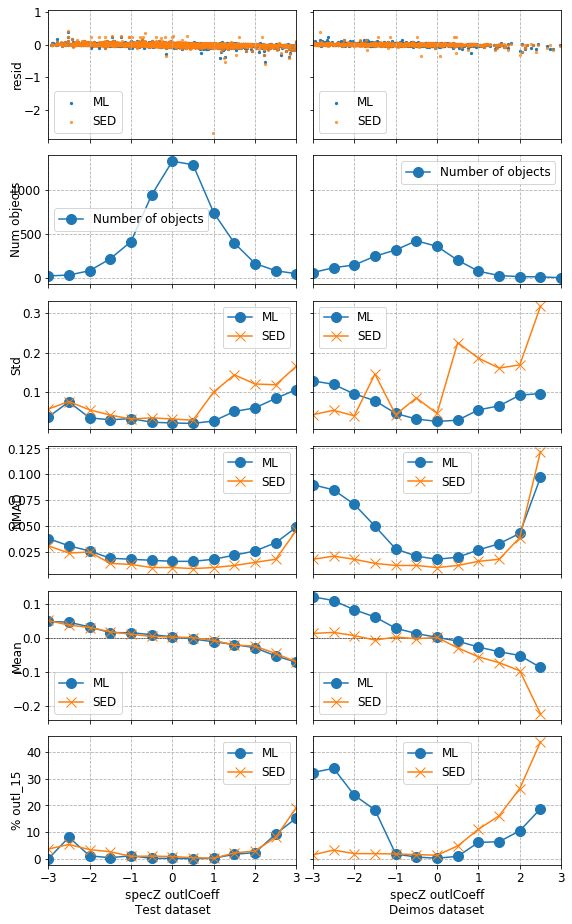

In [124]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
data=[d[d['trainMapOccupation']>=5] for d in data]
stats=[statAll[name] for name in datasetNamesPlot]
case=[specZ,specZ]
fig=plotStatsForOutlCoeff3(data,case,stats,datasetNamesPlot,lims=(-3,3),activMap=False)

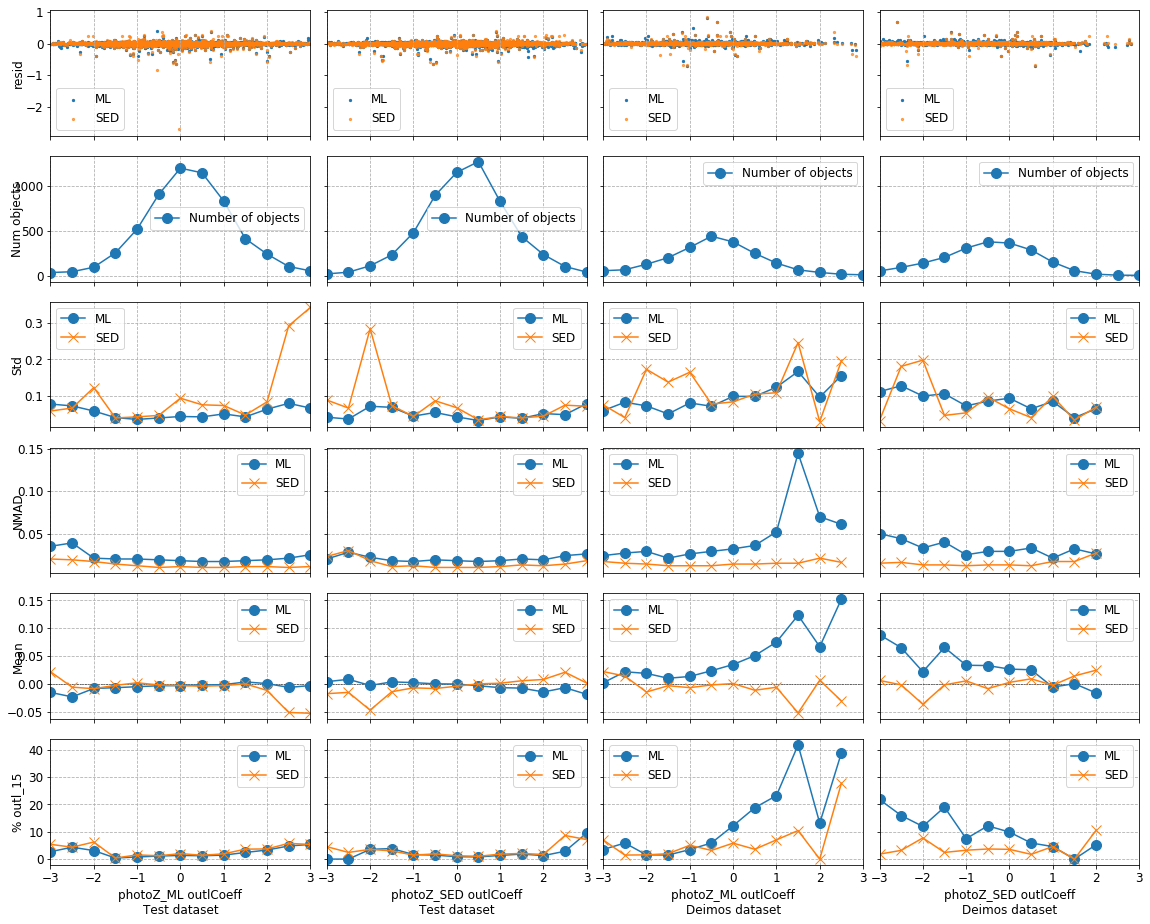

In [125]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Test','Deimos','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
data=[d[d['trainMapOccupation']>=5] for d in data]
stats=[statAll[name] for name in datasetNamesPlot]
case=[photoZ_ML,photoZ_SED,photoZ_ML,photoZ_SED]
fig=plotStatsForOutlCoeff3(data,case,stats,datasetNamesPlot,lims=(-3,3))

In [126]:
def plotStatsForOutlCoeff5(data,case,stats,datasetNames,lims=(-3,3)):
    fig,axs=plt.subplots(6,len(data),figsize=(4*len(data),18),sharey='row',sharex='col')
    if len(data)==1:
        axs=[[ax] for ax in axs]
    estimators=['Std','NMAD','Mean','% outl_15']
    i=0
    textSize=13
    for j,d in enumerate(data):
        c=case[j]
        axs[i][j].set_xlim(lims)
        c=c.replace('_activMapClean','')
        c=c.replace('outlCoeff_','')+'_outlCoeff'
        axs[i][j].scatter(d[c],d[residML],s=5,label='ML')
        axs[i][j].scatter(d[c],d[residSED],s=5,label='SED',alpha=0.7)
        axs[i][j].set_ylim(-0.5,0.5)
        axs[i][j].grid(axis='x',linestyle ='--')
    
        leg = axs[i][j].legend(fontsize=textSize)
        leg.get_frame().set_linewidth(2.0)
        axs[i][j].tick_params(axis='both', labelsize=textSize)
    axs[i][0].set_ylabel('resid',size=textSize)
    axs[i][0].yaxis.set_label_coords(-0.18, 0.5)

    i=1
    for j,s in enumerate(stats):
        k=case[j]
        axs[i][j].set_xlim(lims)
        axs[i][j].plot(s[k]['General']['binEdge'],s[k]['General']['Num objects'],
                       markersize=8,label='Number of objects',marker='s', color='black')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].grid(axis='y',linestyle ='--')
        leg=axs[i][j].legend(fontsize=textSize)
        leg.get_frame().set_linewidth(2.0)
        axs[i][j].tick_params(axis='both', labelsize=textSize)
    axs[i][0].set_ylabel('Num objects',size=textSize)
    axs[i][0].yaxis.set_label_coords(-0.18, 0.5)

    ii=2
    for i,est in enumerate(estimators):
        for j,s in enumerate(stats):
            k=case[j]
            axs[i+ii][j].grid(axis='y',linestyle ='--')
            axs[i+ii][j].grid(axis='x',linestyle ='--')
            if est=='Mean':
                axs[i+ii][j].axhline(0,color='black',ls='--',lw=0.5)
            s=s[k][(s[k]['General']['binEdge']>=lims[0]) & 
                                (s[k]['General']['binEdge']<=lims[1])]
            s=s.mask(s['General']['Num objects']<=15)
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residML][est],markersize=8,label='ML',marker='o')
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residSED][est],markersize=8,label='SED',marker='x')
            axs[i+ii][j].set_xlim(lims)
            axs[i+ii][j].tick_params(axis='both', labelsize=textSize)
            
            leg=axs[i+ii][j].legend(fontsize=textSize)
            leg.get_frame().set_linewidth(2.0)
        axs[i+ii][0].set_ylabel(est,size=textSize)
        axs[i+ii][0].yaxis.set_label_coords(-0.18, 0.5)
    for j in range(len(datasetNames)):
        if '_activMap' in case[j]:
            xlabel=case[j].replace('_activMapClean','')+' \n'+ datasetNames[j]+' dataset \n after activMap filtering'
        else:
            xlabel=case[j]+' \n'+ datasetNames[j]+' dataset \n '
        axs[-1][j].set_xlabel(xlabel,size=textSize)
    plt.tight_layout()
    return fig,axs

Text(0.5, 137.99999999999986, '$K_\\mathrm{spec}$\nDeimos dataset\n after occupation map filtering')

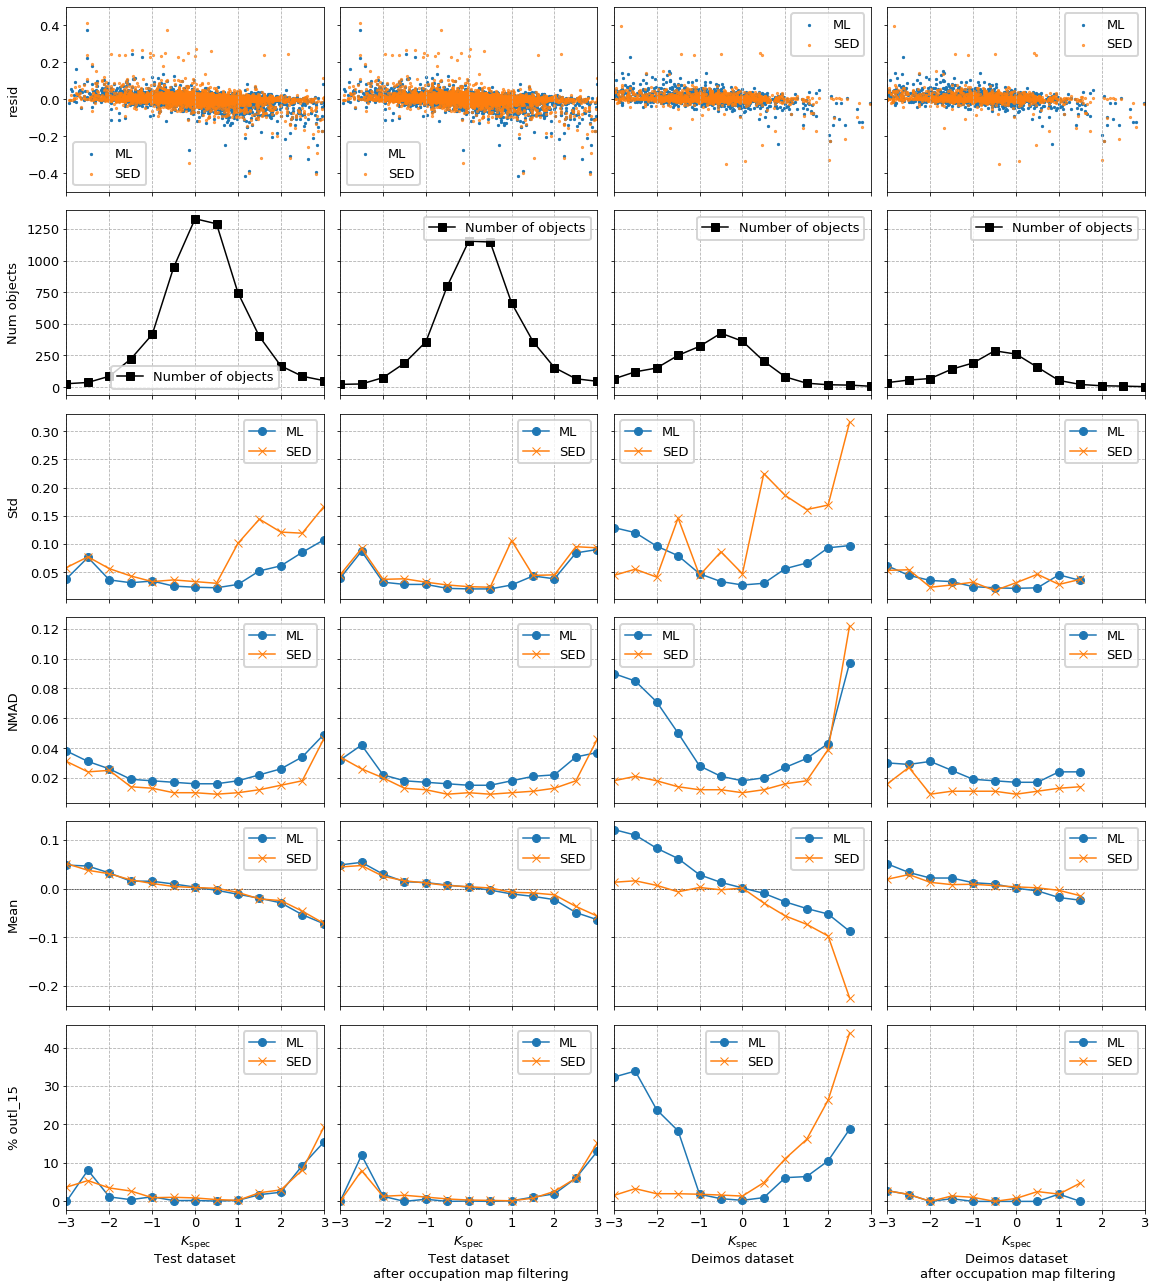

In [127]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Test','Deimos','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
data=[d[d['trainMapOccupation']>=5] for d in data]
stats=[statAll[name] for name in datasetNamesPlot]
case=['outlCoeff_'+specZ,'outlCoeff_'+specZ+'_activMapClean','outlCoeff_'+specZ,'outlCoeff_'+specZ+'_activMapClean']
fig,axs=plotStatsForOutlCoeff5(data,case,stats,datasetNamesPlot,lims=(-3,3))
axs[-1][0].set_xlabel(r'$K_\mathrm{spec}$'+'\n'+ datasetNamesPlot[0]+' dataset')
axs[-1][1].set_xlabel(r'$K_\mathrm{spec}$'+'\n'+ datasetNamesPlot[1]+' dataset\n after occupation map filtering')
axs[-1][2].set_xlabel(r'$K_\mathrm{spec}$'+'\n'+ datasetNamesPlot[2]+' dataset')
axs[-1][3].set_xlabel(r'$K_\mathrm{spec}$'+'\n'+ datasetNamesPlot[3]+' dataset\n after occupation map filtering')

In [145]:
def plotYerrCalc(est,vals,numObjs,lims):
    yerr=None
    if est=='Mean':
        yerr=vals/np.sqrt(numObjs)
        yerr=yerr[(yerr.index>=lims[0]) & (yerr.index<=lims[1])]
        yerr=yerr.mask(numObjs<=15)
    elif est=='Std':
        yerr=vals/(2*np.sqrt(numObjs))
        yerr=yerr[(yerr.index>=lims[0]) & (yerr.index<=lims[1])]
        yerr=yerr.mask(numObjs<=15)
    elif est=='% outl_15':
        Ntot=numObjs
        Nbad=vals*numObjs
        temp=Nbad*(Ntot+Nbad)/Ntot
        yerr=(1/Ntot)*np.sqrt(list(temp))
        yerr=yerr[(yerr.index>=lims[0]) & (yerr.index<=lims[1])]
        yerr=yerr.mask(numObjs<=15)
    return yerr

In [148]:
def plotStatsForOutlCoeff6(data,case,stats,datasetNames,lims=(-3,3)):
    fig,axs=plt.subplots(6,len(data),figsize=(4*len(data),18),sharey='row',sharex='col')
    if len(data)==1:
        axs=[[ax] for ax in axs]
    estimators=['Std','NMAD','Mean','% outl_15']
    i=0
    textSize=13
    numObjs={}
    for j,d in enumerate(data):
        c=case[j]
        axs[i][j].set_xlim(lims)
        c=c.replace('_activMapClean','')
        c=c.replace('outlCoeff_','')+'_outlCoeff'
        axs[i][j].scatter(d[c],d[residML],s=5,label='ML')
        axs[i][j].scatter(d[c],d[residSED],s=5,label='SED',alpha=0.7)
        axs[i][j].set_ylim(-0.5,0.5)
        axs[i][j].grid(axis='x',linestyle ='--')
    
        leg = axs[i][j].legend(fontsize=textSize)
        leg.get_frame().set_linewidth(2.0)
        axs[i][j].tick_params(axis='both', labelsize=textSize)
    axs[i][0].set_ylabel('resid',size=textSize)
    axs[i][0].yaxis.set_label_coords(-0.18, 0.5)

    i=1
    for j,s in enumerate(stats):
        k=case[j]
        axs[i][j].set_xlim(lims)
        
        numObjs[k]=s[k]['General']['Num objects']
        axs[i][j].plot(s[k]['General']['binEdge'],s[k]['General']['Num objects'],
                       markersize=8,label='Number of objects',marker='s', color='black')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].grid(axis='y',linestyle ='--')
        leg=axs[i][j].legend(fontsize=textSize)
        leg.get_frame().set_linewidth(2.0)
        axs[i][j].tick_params(axis='both', labelsize=textSize)
    axs[i][0].set_ylabel('Num objects',size=textSize)
    axs[i][0].yaxis.set_label_coords(-0.18, 0.5)

    ii=2
    for i,est in enumerate(estimators):
        for j,s in enumerate(stats):
            k=case[j]
            axs[i+ii][j].grid(axis='y',linestyle ='--')
            axs[i+ii][j].grid(axis='x',linestyle ='--')
            if est=='Mean':
                axs[i+ii][j].axhline(0,color='black',ls='--',lw=0.5)
            s=s[k][(s[k]['General']['binEdge']>=lims[0]) & 
                                (s[k]['General']['binEdge']<=lims[1])]
            s=s.mask(s['General']['Num objects']<=15)
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residML][est],markersize=8,label='ML',marker='o')
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residSED][est],markersize=8,label='SED',marker='x')
            axs[i+ii][j].set_xlim(lims)
            axs[i+ii][j].tick_params(axis='both', labelsize=textSize)
            
            if est=='Mean' or est=='Std' or est=='% outl_15':
                vals=s[residML][est]
                yerr=plotYerrCalc(est,vals,numObjs[k],lims)
                axs[i+ii][j].errorbar(s['General']['binEdge'],vals,
                                     yerr=yerr,c='#1f77b4',capsize=5)          
                
                vals=s[residSED][est]
                yerr=plotYerrCalc(est,vals,numObjs[k],lims)
                axs[i+ii][j].errorbar(s['General']['binEdge'],vals,
                                     yerr=yerr,c='#ff7f0e',capsize=5) 
                
            leg=axs[i+ii][j].legend(fontsize=textSize)
            leg.get_frame().set_linewidth(2.0)
        axs[i+ii][0].set_ylabel(est,size=textSize)
        axs[i+ii][0].yaxis.set_label_coords(-0.18, 0.5)
    for j in range(len(datasetNames)):
        if '_activMap' in case[j]:
            xlabel=case[j].replace('_activMapClean','')+' \n'+ datasetNames[j]+' dataset \n after activMap filtering'
        else:
            xlabel=case[j]+' \n'+ datasetNames[j]+' dataset \n '
        axs[-1][j].set_xlabel(xlabel,size=textSize)
    plt.tight_layout()
    return fig,axs

Text(0.5, 137.99999999999986, '$K_\\mathrm{spec}$\nDeimos dataset\n after occupation map filtering')

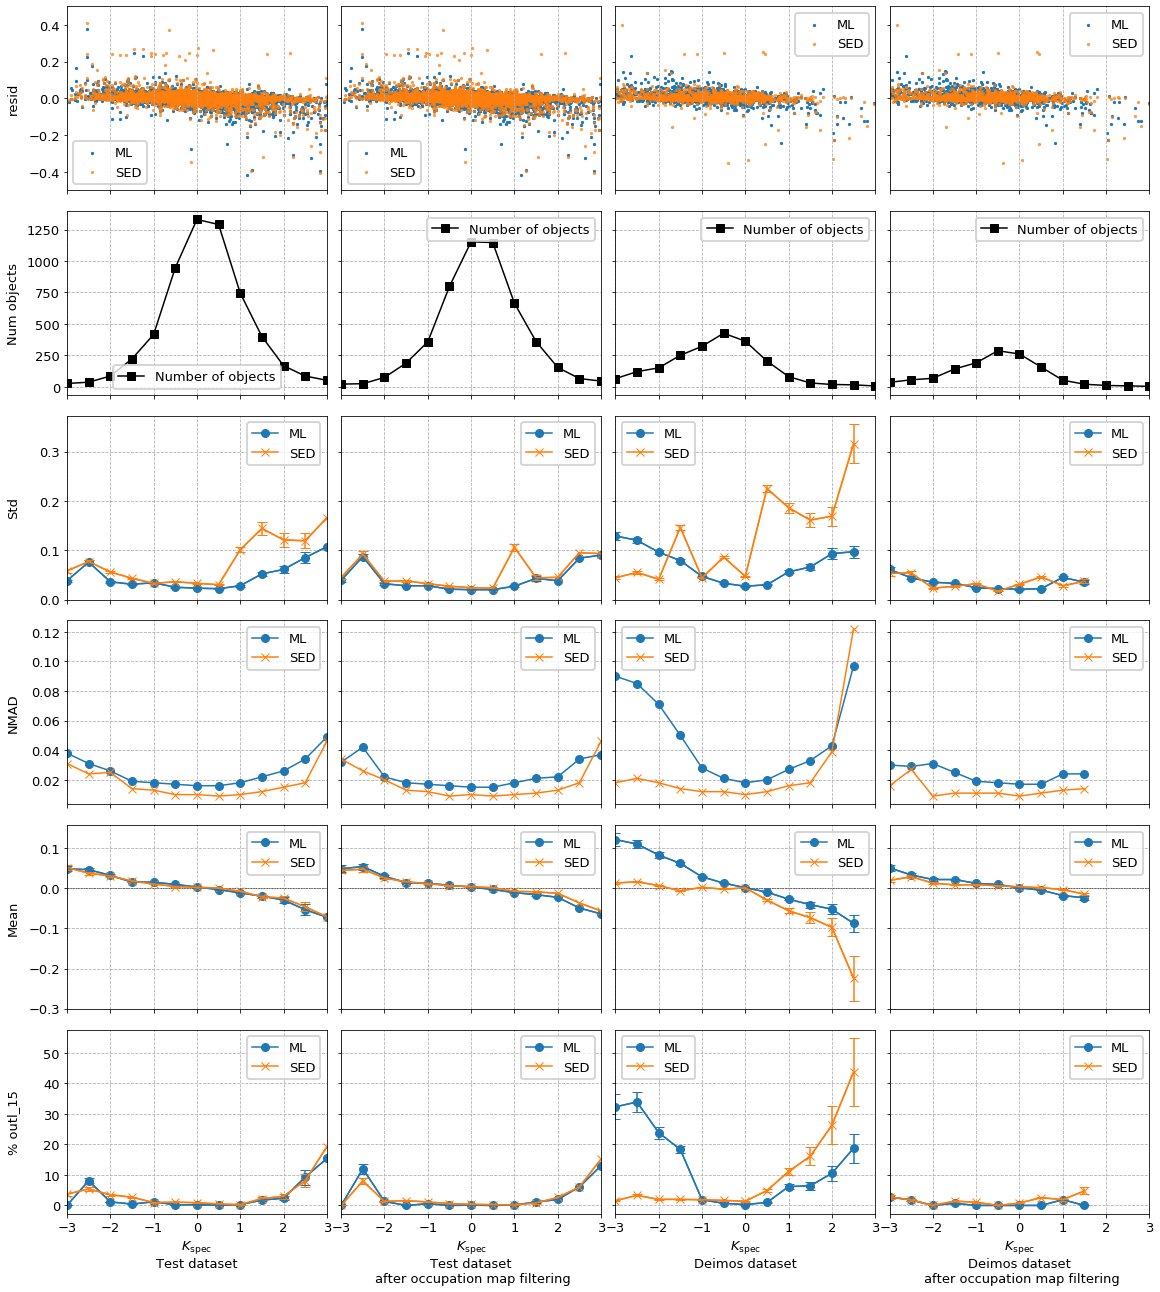

In [149]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Test','Deimos','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
data=[d[d['trainMapOccupation']>=5] for d in data]
stats=[statAll[name] for name in datasetNamesPlot]
case=['outlCoeff_'+specZ,'outlCoeff_'+specZ+'_activMapClean','outlCoeff_'+specZ,'outlCoeff_'+specZ+'_activMapClean']
fig,axs=plotStatsForOutlCoeff6(data,case,stats,datasetNamesPlot,lims=(-3,3))
axs[-1][0].set_xlabel(r'$K_\mathrm{spec}$'+'\n'+ datasetNamesPlot[0]+' dataset')
axs[-1][1].set_xlabel(r'$K_\mathrm{spec}$'+'\n'+ datasetNamesPlot[1]+' dataset\n after occupation map filtering')
axs[-1][2].set_xlabel(r'$K_\mathrm{spec}$'+'\n'+ datasetNamesPlot[2]+' dataset')
axs[-1][3].set_xlabel(r'$K_\mathrm{spec}$'+'\n'+ datasetNamesPlot[3]+' dataset\n after occupation map filtering')

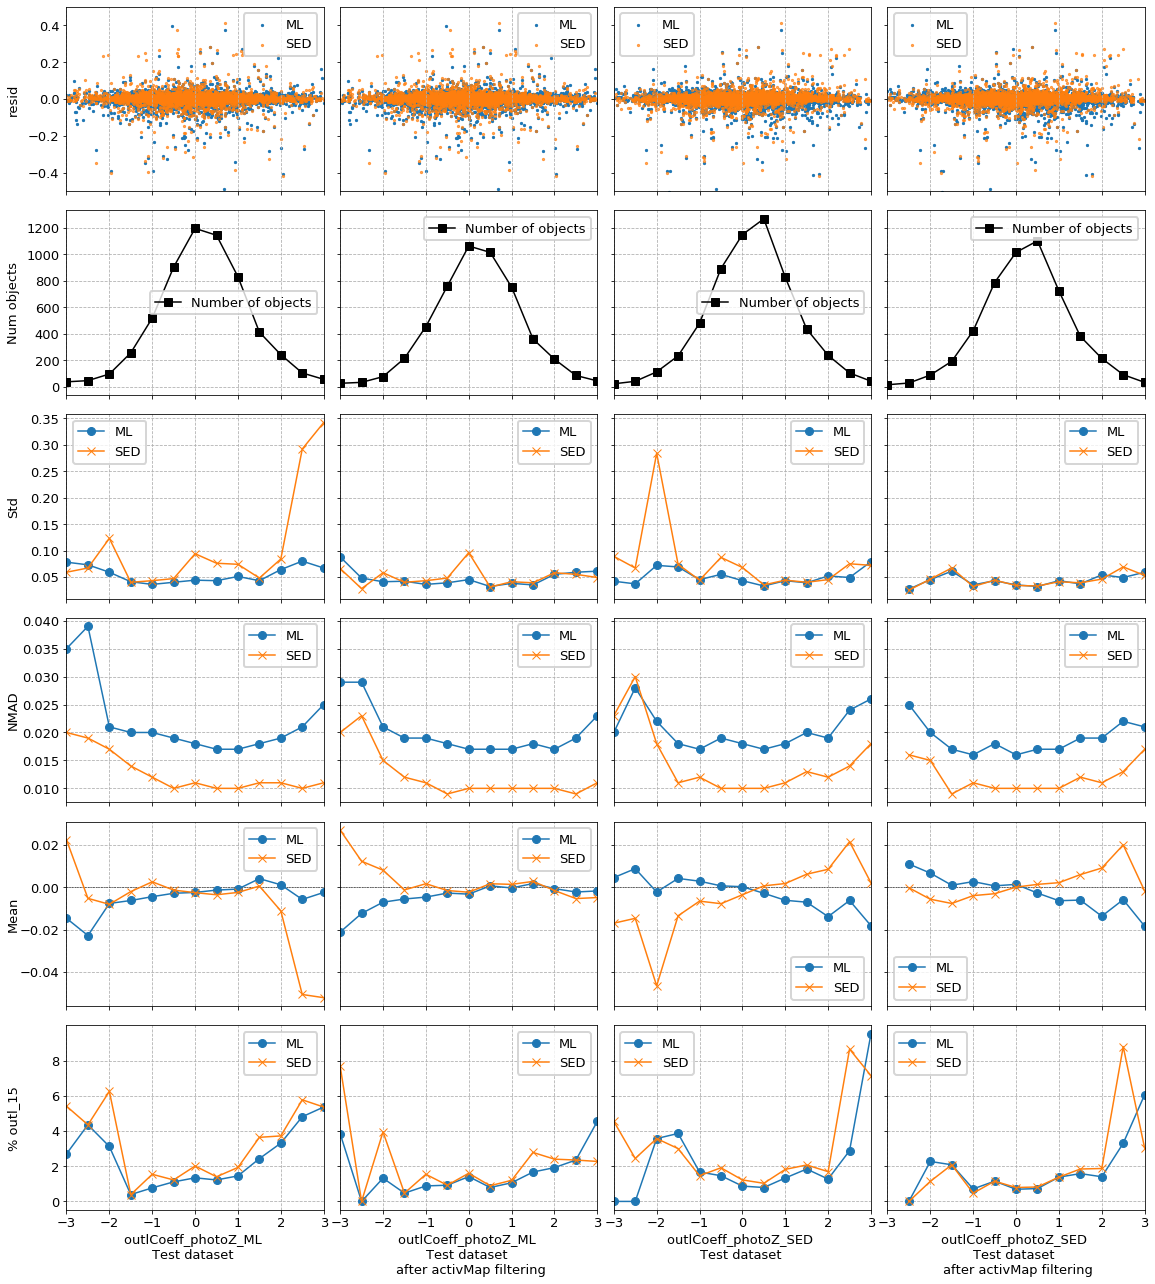

In [128]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Test','Test','Test']
data=[datasets[name] for name in datasetNamesPlot]
data=[d[d['trainMapOccupation']>=5] for d in data]
stats=[statAll[name] for name in datasetNamesPlot]
case=['outlCoeff_'+photoZ_ML,'outlCoeff_'+photoZ_ML+'_activMapClean',
      'outlCoeff_'+photoZ_SED,'outlCoeff_'+photoZ_SED+'_activMapClean']
fig=plotStatsForOutlCoeff5(data,case,stats,datasetNamesPlot,lims=(-3,3))

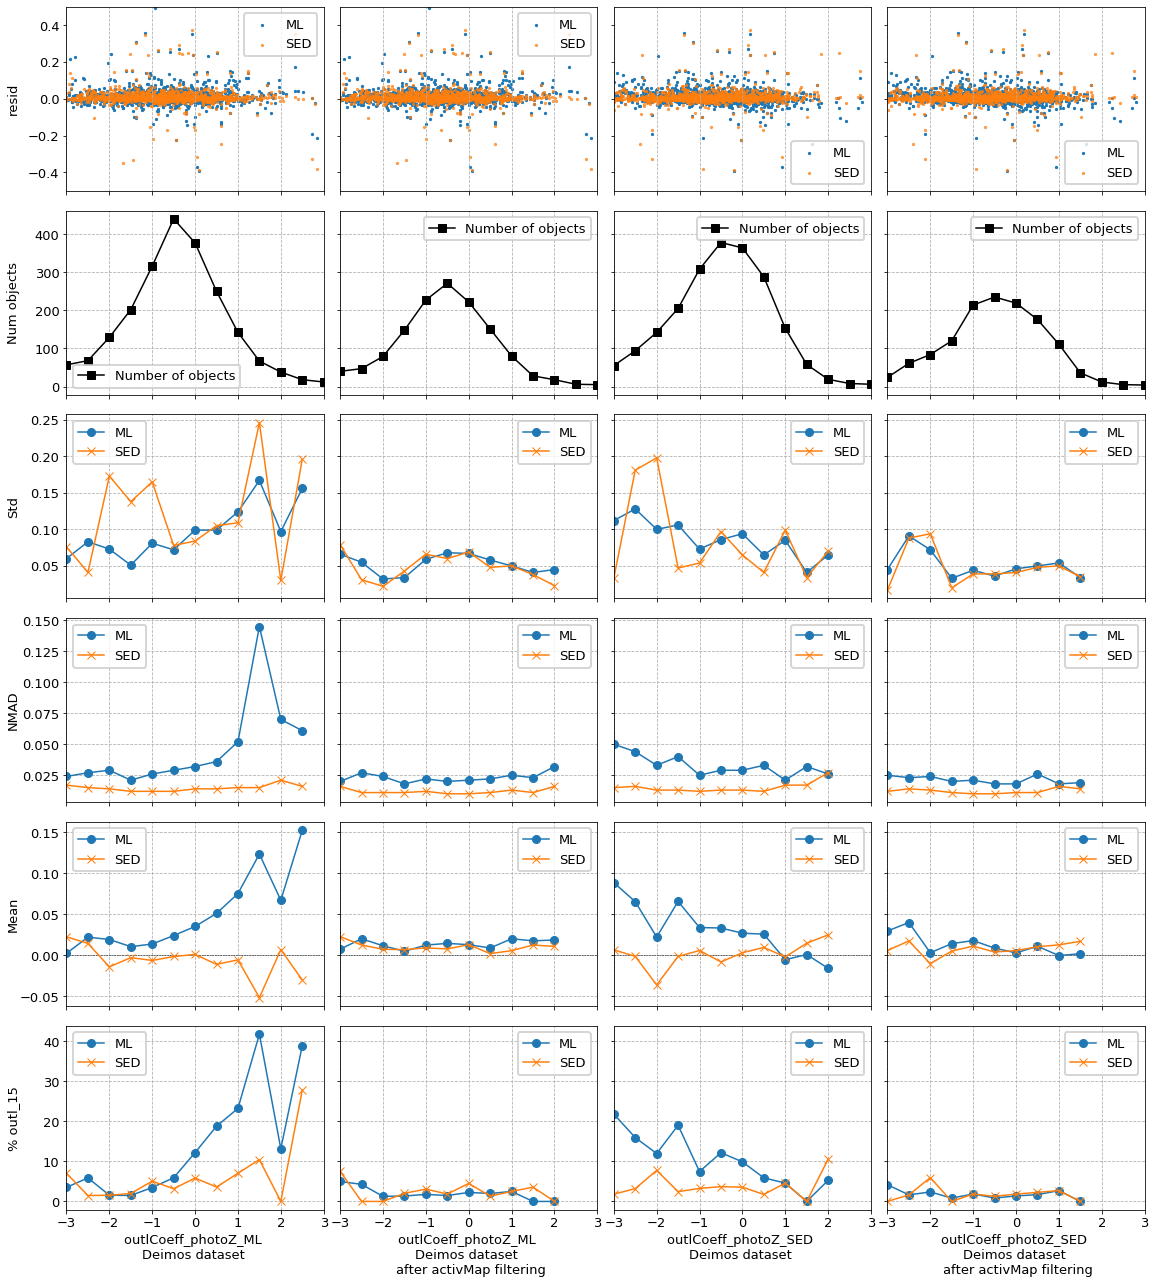

In [129]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Deimos','Deimos','Deimos','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
data=[d[d['trainMapOccupation']>=5] for d in data]
stats=[statAll[name] for name in datasetNamesPlot]
case=['outlCoeff_'+photoZ_ML,'outlCoeff_'+photoZ_ML+'_activMapClean',
      'outlCoeff_'+photoZ_SED,'outlCoeff_'+photoZ_SED+'_activMapClean']
fig=plotStatsForOutlCoeff5(data,case,stats,datasetNamesPlot,lims=(-3,3))

In [130]:
from matplotlib.ticker import FormatStrFormatter

In [131]:
def plotAxScatter(ax,d,xlimmin,xlimmax,ylimmin,ylimmax,title):
    ax.scatter(d[specZ],d[photoZ_ML],label='ML',s=5)
    ax.scatter(d[specZ],d[photoZ_SED],label='SED',s=5)
    ax.plot(d[specZ],d[specZ],lw=0.5,c='black')
    ax.plot(d[specZ],d[specZ]+0.15*(1+d[specZ]),linewidth=0.5,linestyle='dashed',c='gray')
    ax.plot(d[specZ],d[specZ]-0.15*(1+d[specZ]),linewidth=0.5,linestyle='dashed',c='gray')
    ax.set_xlim(xlimmin,xlimmax)
    ax.set_ylim(ylimmin,ylimmax)
    ax.set_xlabel('spec-z')
    ax.set_ylabel('photo-z')
    ax.legend()
    ax.set_title(title)
    ax.set_aspect(1, adjustable='box')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    return ax

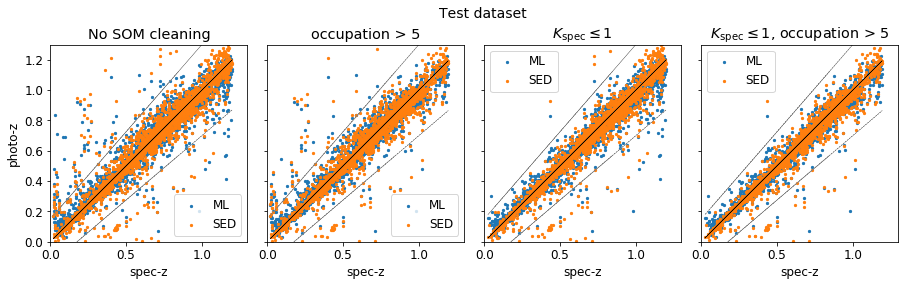

In [132]:
fig,axs=plt.subplots(1,4,figsize=(15.2,3.8),sharey='row',sharex='col')
fig.suptitle('Test dataset', fontsize=14,y=1.0,x=0.52)
xlimmin=0
xlimmax=1.3
ylimmin=0
ylimmax=1.3
d=datasets['Test']
ax=axs[0]
plotAxScatter(ax,d,xlimmin,xlimmax,ylimmin,ylimmax,title='No SOM cleaning')

d=datasets['Test']
d=d[d['trainMapOccupation']>5]
ax=axs[1]
plotAxScatter(ax,d,xlimmin,xlimmax,ylimmin,ylimmax,title='occupation > 5')
ax.set_ylabel(None)

d=datasets['Test']
d=d[d['specZ_outlCoeff']<=1]
ax=axs[2]
plotAxScatter(ax,d,xlimmin,xlimmax,ylimmin,ylimmax,title=r'$K_\mathrm{spec} \leq 1$')
ax.set_ylabel(None)

d=datasets['Test']
d=d[d['trainMapOccupation']>5]
d=d[d['specZ_outlCoeff']<=1]
ax=axs[3]
plotAxScatter(ax,d,xlimmin,xlimmax,ylimmin,ylimmax,title=r'$K_\mathrm{spec} \leq 1$'+', occupation > 5')
ax.set_ylabel(None)
#plt.tight_layout(pad=0.01)
plt.subplots_adjust(wspace=0.1)

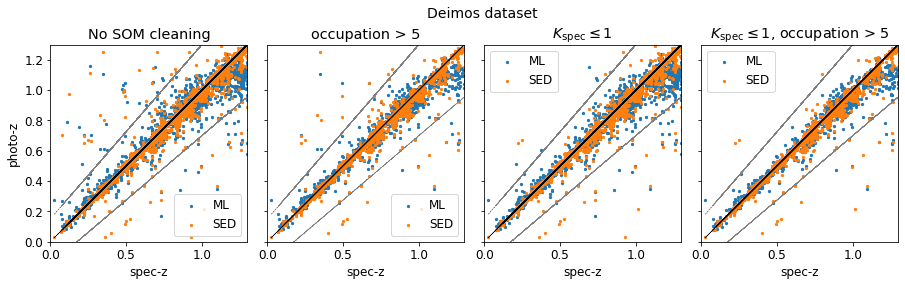

In [133]:
fig,axs=plt.subplots(1,4,figsize=(15.2,3.8),sharey='row',sharex='col')
fig.suptitle('Deimos dataset', fontsize=14,y=1.0,x=0.52)
xlimmin=0
xlimmax=1.3
ylimmin=0
ylimmax=1.3
d=datasets['Deimos']
ax=axs[0]
plotAxScatter(ax,d,xlimmin,xlimmax,ylimmin,ylimmax,title='No SOM cleaning')

d=datasets['Deimos']
d=d[d['trainMapOccupation']>5]
ax=axs[1]
plotAxScatter(ax,d,xlimmin,xlimmax,ylimmin,ylimmax,title='occupation > 5')
ax.set_ylabel(None)

d=datasets['Deimos']
d=d[d['specZ_outlCoeff']<=1]
ax=axs[2]
plotAxScatter(ax,d,xlimmin,xlimmax,ylimmin,ylimmax,title=r'$K_\mathrm{spec} \leq 1$')
ax.set_ylabel(None)

d=datasets['Deimos']
d=d[d['trainMapOccupation']>5]
d=d[d['specZ_outlCoeff']<=1]
ax=axs[3]
plotAxScatter(ax,d,xlimmin,xlimmax,ylimmin,ylimmax,title=r'$K_\mathrm{spec} \leq 1$'+', occupation > 5')
ax.set_ylabel(None)
#plt.tight_layout(pad=0.01)
plt.subplots_adjust(wspace=0.1)

### General statistics table
<a id='statTab'>#statTab</a>

In [134]:
statAll['Test']['Basic'][['resid_ML','resid_SED','General']]

resid_ML                 \
                                                      Std   NMAD    Mean   
case                                                                       
No filtering                                        0.048  0.019 -0.0023   
trainMapOccupation>5                                0.041  0.018 -0.0021   
specZ_outlCoeff<=1                                  0.025  0.017  0.0002   
specZ_outlCoeff + occupation filters                0.022  0.016 -0.0002   
photoZ_ML_outlCoeff<=1                              0.045  0.018  -0.002   
photoZ_ML_outlCoeff + occupation filters            0.039  0.017 -0.0015   
photoZ_SED_outlCoeff<=1                             0.043  0.018  -0.002   
photoZ_SED_outlCoeff + occupation filters           0.038  0.017 -0.0016   
photoZ_ML_outlCoeff<=1, specZ_outlCoeff<=1           0.02  0.016  0.0007   
photoZ_ML_outlCoeff+ specZ + occupation filters     0.019  0.015  0.0004   
photoZ_SED_outlCoeff<=1, specZ_outlCoeff<=1         0.021  0.016  0.0004   
photoZ_SED_outlCoeff+ specZ + occupation filters     0.02  0.016  0.0003   

                                                           resid_SED         \
                                                 % outl_15       Std   NMAD   
case                                                                          
No filtering                                          1.64     0.094  0.011   
trainMapOccupation>5                                  1.18     0.058   0.01   
specZ_outlCoeff<=1                                    0.19     0.052   0.01   
specZ_outlCoeff + occupation filters                  0.05      0.05  0.009   
photoZ_ML_outlCoeff<=1                                1.28     0.077   0.01   
photoZ_ML_outlCoeff + occupation filters              1.06     0.062   0.01   
photoZ_SED_outlCoeff<=1                               1.06     0.061   0.01   
photoZ_SED_outlCoeff + occupation filters             0.94     0.038   0.01   
photoZ_ML_outlCoeff<=1, specZ_outlCoeff<=1               0     0.053   0.01   
photoZ_ML_outlCoeff+ specZ + occupation filters          0     0.052  0.009   
photoZ_SED_outlCoeff<=1, specZ_outlCoeff<=1              0     0.024  0.009   
photoZ_SED_outlCoeff+ specZ + occupation filters         0     0.016  0.009   

                                                                       General  
                                                    Mean % outl_15 Num objects  
case                                                                            
No filtering                                     -0.0041      2.23      5967.0  
trainMapOccupation>5                              0.0001      1.49      5167.0  
specZ_outlCoeff<=1                                0.0006       0.7      4311.0  
specZ_outlCoeff + occupation filters              0.0018      0.35      3761.0  
photoZ_ML_outlCoeff<=1                           -0.0026      1.65      4071.0  
photoZ_ML_outlCoeff + occupation filters         -0.0003      1.17      3587.0  
photoZ_SED_outlCoeff<=1                          -0.0021      1.43      4133.0  
photoZ_SED_outlCoeff + occupation filters         0.0002      0.99      3624.0  
photoZ_ML_outlCoeff<=1, specZ_outlCoeff<=1         0.001      0.39      3553.0  
photoZ_ML_outlCoeff+ specZ + occupation filters   0.0017      0.19      3151.0  
photoZ_SED_outlCoeff<=1, specZ_outlCoeff<=1       0.0008      0.24      3682.0  
photoZ_SED_outlCoeff+ specZ + occupation filters  0.0018         0      3253.0

In [135]:
statAll['Deimos']['Basic'][['General','resid_ML','resid_SED']]

General resid_ML         \
                                                 Num objects      Std   NMAD   
case                                                                           
No filtering                                          2255.0    0.099  0.032   
trainMapOccupation>5                                  1382.0    0.058  0.023   
specZ_outlCoeff<=1                                    1075.0    0.035   0.02   
specZ_outlCoeff + occupation filters                   758.0    0.025  0.018   
photoZ_ML_outlCoeff<=1                                1209.0    0.095  0.033   
photoZ_ML_outlCoeff + occupation filters               724.0    0.064  0.022   
photoZ_SED_outlCoeff<=1                               1183.0    0.085  0.029   
photoZ_SED_outlCoeff + occupation filters              741.0    0.046   0.02   
photoZ_ML_outlCoeff<=1, specZ_outlCoeff<=1             790.0     0.03  0.018   
photoZ_ML_outlCoeff+ specZ + occupation filters        574.0    0.023  0.017   
photoZ_SED_outlCoeff<=1, specZ_outlCoeff<=1            848.0    0.031  0.019   
photoZ_SED_outlCoeff+ specZ + occupation filters       613.0    0.024  0.018   

                                                                   resid_SED  \
                                                    Mean % outl_15       Std   
case                                                                           
No filtering                                      0.0347     10.86     0.142   
trainMapOccupation>5                              0.0127       2.1     0.059   
specZ_outlCoeff<=1                                0.0018      1.02     0.127   
specZ_outlCoeff + occupation filters              0.0017      0.13     0.031   
photoZ_ML_outlCoeff<=1                            0.0392     12.57      0.09   
photoZ_ML_outlCoeff + occupation filters          0.0136      1.93      0.06   
photoZ_SED_outlCoeff<=1                           0.0245      8.96     0.078   
photoZ_SED_outlCoeff + occupation filters         0.0063      1.48     0.044   
photoZ_ML_outlCoeff<=1, specZ_outlCoeff<=1        0.0049      0.63     0.063   
photoZ_ML_outlCoeff+ specZ + occupation filters   0.0039         0     0.027   
photoZ_SED_outlCoeff<=1, specZ_outlCoeff<=1       0.0019      0.47     0.048   
photoZ_SED_outlCoeff+ specZ + occupation filters  0.0018         0     0.017   

                                                                           
                                                   NMAD    Mean % outl_15  
case                                                                       
No filtering                                      0.014 -0.0082      5.06  
trainMapOccupation>5                              0.012  0.0085      2.68  
specZ_outlCoeff<=1                                0.011 -0.0103      2.88  
specZ_outlCoeff + occupation filters               0.01  0.0038      0.92  
photoZ_ML_outlCoeff<=1                            0.013 -0.0031      4.55  
photoZ_ML_outlCoeff + occupation filters          0.011   0.008      2.62  
photoZ_SED_outlCoeff<=1                           0.013  0.0005       3.3  
photoZ_SED_outlCoeff + occupation filters         0.011  0.0075      1.89  
photoZ_ML_outlCoeff<=1, specZ_outlCoeff<=1        0.011 -0.0031      2.41  
photoZ_ML_outlCoeff+ specZ + occupation filters    0.01  0.0048      0.87  
photoZ_SED_outlCoeff<=1, specZ_outlCoeff<=1        0.01  0.0003      0.94  
photoZ_SED_outlCoeff+ specZ + occupation filters   0.01  0.0049      0.16

In [136]:
statAll['Deimos']['Basic'][['residML_SED','General']]

residML_SED                 \
                                                         Std   NMAD    Mean   
case                                                                          
No filtering                                           0.102  0.033  0.0355   
trainMapOccupation>5                                   0.047  0.023  0.0031   
specZ_outlCoeff<=1                                      0.07  0.023  0.0049   
specZ_outlCoeff + occupation filters                   0.036   0.02 -0.0028   
photoZ_ML_outlCoeff<=1                                 0.088  0.034  0.0392   
photoZ_ML_outlCoeff + occupation filters               0.043  0.022  0.0048   
photoZ_SED_outlCoeff<=1                                0.072   0.03  0.0224   
photoZ_SED_outlCoeff + occupation filters               0.03  0.022 -0.0015   
photoZ_ML_outlCoeff<=1, specZ_outlCoeff<=1             0.049  0.021  0.0055   
photoZ_ML_outlCoeff+ specZ + occupation filters        0.035  0.019 -0.0016   
photoZ_SED_outlCoeff<=1, specZ_outlCoeff<=1            0.038  0.022  0.0003   
photoZ_SED_outlCoeff+ specZ + occupation filters       0.025   0.02 -0.0032   

                                                               General  
                                                 % outl_15 Num objects  
case                                                                    
No filtering                                         11.35      2255.0  
trainMapOccupation>5                                  1.52      1382.0  
specZ_outlCoeff<=1                                    2.88      1075.0  
specZ_outlCoeff + occupation filters                  0.92       758.0  
photoZ_ML_outlCoeff<=1                               11.75      1209.0  
photoZ_ML_outlCoeff + occupation filters              0.97       724.0  
photoZ_SED_outlCoeff<=1                               7.44      1183.0  
photoZ_SED_outlCoeff + occupation filters             0.27       741.0  
photoZ_ML_outlCoeff<=1, specZ_outlCoeff<=1            2.03       790.0  
photoZ_ML_outlCoeff+ specZ + occupation filters        0.7       574.0  
photoZ_SED_outlCoeff<=1, specZ_outlCoeff<=1           0.71       848.0  
photoZ_SED_outlCoeff+ specZ + occupation filters         0       613.0

In [25]:
statAll['Run']['Basic']

residML_SED                 \
                                                  Std   NMAD    Mean   
case                                                                   
No filtering                                    0.238  0.129  0.1373   
trainMapOccupation>5                            0.083  0.028 -0.0019   
photoZ_ML_outlCoeff<=1                          0.225   0.11  0.1243   
photoZ_ML_outlCoeff + occupation filters         0.08  0.028 -0.0029   
photoZ_SED_outlCoeff<=1                         0.206  0.101  0.1217   
photoZ_SED_outlCoeff + occupation filters       0.056  0.026 -0.0031   

                                                        General  
                                          % outl_15 Num objects  
case                                                             
No filtering                                  40.23    194509.0  
trainMapOccupation>5                           3.59     43279.0  
photoZ_ML_outlCoeff<=1                        37.76    137152.0  
photoZ_ML_outlCoeff + occupation filters       3.48     33296.0  
photoZ_SED_outlCoeff<=1                       34.93    146773.0  
photoZ_SED_outlCoeff + occupation filters      2.17     35189.0

In [32]:
statAll['Test']['specZBins'][['General','resid_ML','resid_SED']]

General         resid_ML                          resid_SED         \
    Num objects binEdge      Std   NMAD    Mean % outl_15       Std   NMAD   
0.2       422.0     0.2      0.1  0.027 -0.0416      8.29     0.278  0.012   
0.4      1445.0     0.4    0.043  0.016 -0.0081      1.31     0.056  0.008   
0.6      1158.0     0.6    0.038  0.016  0.0003      1.04     0.067   0.01   
0.8      1489.0     0.8    0.036  0.018  0.0001      1.01     0.052  0.012   
1.0      1085.0     1.0    0.032  0.019  0.0041      0.55     0.044  0.014   
1.2       368.0     1.2    0.051  0.028  0.0292      2.99     0.094  0.027   

                       
       Mean % outl_15  
0.2 -0.0552      7.82  
0.4 -0.0034      1.94  
0.6 -0.0002      2.07  
0.8  0.0002      1.48  
1.0  0.0057       1.2  
1.2 -0.0068      3.53

In [34]:
statAll['Test']['specZBins_specZ_filt'][['General','resid_ML','resid_SED']]

General         resid_ML                          resid_SED         \
    Num objects binEdge      Std   NMAD    Mean % outl_15       Std   NMAD   
0.2       302.0     0.2    0.032   0.02 -0.0118      0.33     0.156  0.009   
0.4      1098.0     0.4    0.019  0.015 -0.0029         0     0.023  0.008   
0.6       775.0     0.6    0.024  0.015  0.0023      0.13     0.028  0.009   
0.8      1072.0     0.8    0.023  0.016  0.0007      0.09     0.035  0.011   
1.0       842.0     1.0    0.023  0.018  0.0008         0     0.029  0.012   
1.2       222.0     1.2    0.043  0.027  0.0189      2.25     0.061  0.025   

                       
       Mean % outl_15  
0.2 -0.0081      0.33  
0.4  0.0027      0.55  
0.6  0.0013      0.65  
0.8  0.0015      0.56  
1.0  0.0035      0.48  
1.2 -0.0152       3.6

In [35]:
statAll['Test']['specZBins_activMap'][['General','resid_ML','resid_SED']]

General         resid_ML                          resid_SED         \
    Num objects binEdge      Std   NMAD    Mean % outl_15       Std   NMAD   
0.2       361.0     0.2     0.08  0.026 -0.0331       7.2      0.16  0.011   
0.4      1320.0     0.4    0.038  0.015 -0.0062      0.91     0.042  0.008   
0.6      1045.0     0.6    0.037  0.016 -0.0005      0.77     0.042  0.009   
0.8      1310.0     0.8    0.031  0.018  0.0006      0.61     0.034  0.011   
1.0       916.0     1.0     0.03  0.019  0.0044      0.66     0.042  0.013   
1.2       215.0     1.2    0.035  0.024  0.0229      0.47      0.04  0.023   

                       
       Mean % outl_15  
0.2 -0.0261      6.37  
0.4 -0.0015      1.44  
0.6  0.0011      1.63  
0.8  0.0026      0.76  
1.0  0.0059      0.76  
1.2  0.0098      0.47

In [36]:
statAll['Test']['specZBins_activMap_specZ'][['General','resid_ML','resid_SED']]

General         resid_ML                          resid_SED         \
    Num objects binEdge      Std   NMAD    Mean % outl_15       Std   NMAD   
0.2       266.0     0.2    0.032  0.019 -0.0111      0.38     0.166  0.008   
0.4      1020.0     0.4    0.018  0.015 -0.0023         0     0.021  0.008   
0.6       696.0     0.6    0.023  0.015  0.0016      0.14     0.027  0.009   
0.8       953.0     0.8    0.021  0.015  0.0011         0     0.024  0.011   
1.0       713.0     1.0    0.021  0.017  0.0012         0     0.023  0.012   
1.2       113.0     1.2    0.027  0.022  0.0127         0     0.032  0.022   

                       
       Mean % outl_15  
0.2 -0.0094      0.38  
0.4  0.0024      0.49  
0.6  0.0012      0.57  
0.8   0.003      0.21  
1.0  0.0047      0.14  
1.2 -0.0027         0

### Statistics for magnitude binning
<a id='magBin'>#magBin</a>

In [199]:
def plotBinnedStats(stats,estimators,residCols,cases,binCol,labels,xlim=None):
    #colorBlindPalette=['#000000','#E69F00','#009E73','#0072B2','#D55E00','#56B4E9','#F0E442','#CC79A7']
    colorBlindPalette=['#000000','#E69F00','#539e00','#0072B2','#D55E00','#56B4E9','#F0E442','#CC79A7']
    textSize=13
    fig, axs = plt.subplots(len(estimators)+1, len(residCols),figsize=(7*len(residCols),4*len(estimators)),
                            sharey='row',sharex='col')
    if len(residCols)==1:
        axs=[[ax] for ax in axs]
    
    i=0
    for j, c in enumerate(residCols):
        axs[i][j].grid(axis='y',linestyle ='--')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].set_ylabel('Number of objects',size=textSize)
        for k,case in enumerate(cases):
            stat=stats[case]
            if xlim!=None:
                stat=stat[(stat['General']['binEdge']>=xlim[0]) & (stat['General']['binEdge']<=xlim[1])]
            marker='o'
            if c=='resid_SED':
                marker='x'
            axs[i][j].plot(stat['General']['binEdge'],stat['General']['Num objects'],
                           label=labels[k],marker=marker,markersize=10-2*k,c=colorBlindPalette[k])
        axs[i][j].legend(fontsize=textSize-1)
        #axs[i][j].legend(loc='upper center', bbox_to_anchor=(0,j),ncol=4,fontsize=textSize)
        axs[i][j].set_xlim(xlim)
        axs[i][j].tick_params(axis='both', labelsize=textSize)
    axs[i][0].yaxis.set_label_coords(-0.13, 0.5)
    try:
        axs[i][1].yaxis.set_label_coords(-0.02, 0.5)
    except:
        pass
    
    for i,est in enumerate(estimators):
        for j, c in enumerate(residCols):
            axs[i+1][j].grid(axis='y',linestyle ='--')
            axs[i+1][j].grid(axis='x',linestyle ='--')
            axs[i+1][j].set_ylabel(est+' '+c,size=12)
            for k,case in enumerate(cases):
                stat=stats[case]
                if xlim!=None:
                    stat=stat[(stat['General']['binEdge']>=xlim[0]) & (stat['General']['binEdge']<=xlim[1])]
                marker='o'
                if c=='resid_SED':
                    marker='x'
                axs[i+1][j].plot(stat['General']['binEdge'],stat[c][est],
                               label=labels[k],marker=marker,markersize=10-2*k,c=colorBlindPalette[k])
            axs[i+1][j].legend(fontsize=textSize-1)
            axs[i+1][j].set_xlim(xlim)
            axs[i+1][j].tick_params(axis='both', labelsize=textSize)
        axs[i+1][0].yaxis.set_label_coords(-0.13, 0.5)
        try:
            axs[i+1][1].yaxis.set_label_coords(-0.02, 0.5)
        except:
            pass
    
    axs[-1][0].set_xlabel(binCol,size=textSize)
    if len(residCols)>1:
        axs[-1][1].set_xlabel(binCol,size=textSize)
    plt.tight_layout()
    return fig

In [200]:
### Calculate statistics by specZ bins ###
numBins=7
bins=np.linspace(0, 1.2, numBins)
for name in statAll.keys():
    if name=='Run':
        continue
    else:
        residCols=[residML,residSED,residML_SED]
    statAll[name]['specZBins']=statByBins(datasets[name],binCol=specZ,residCols=residCols,bins=bins)

Text(0.525, 1.01, 'Test dataset')

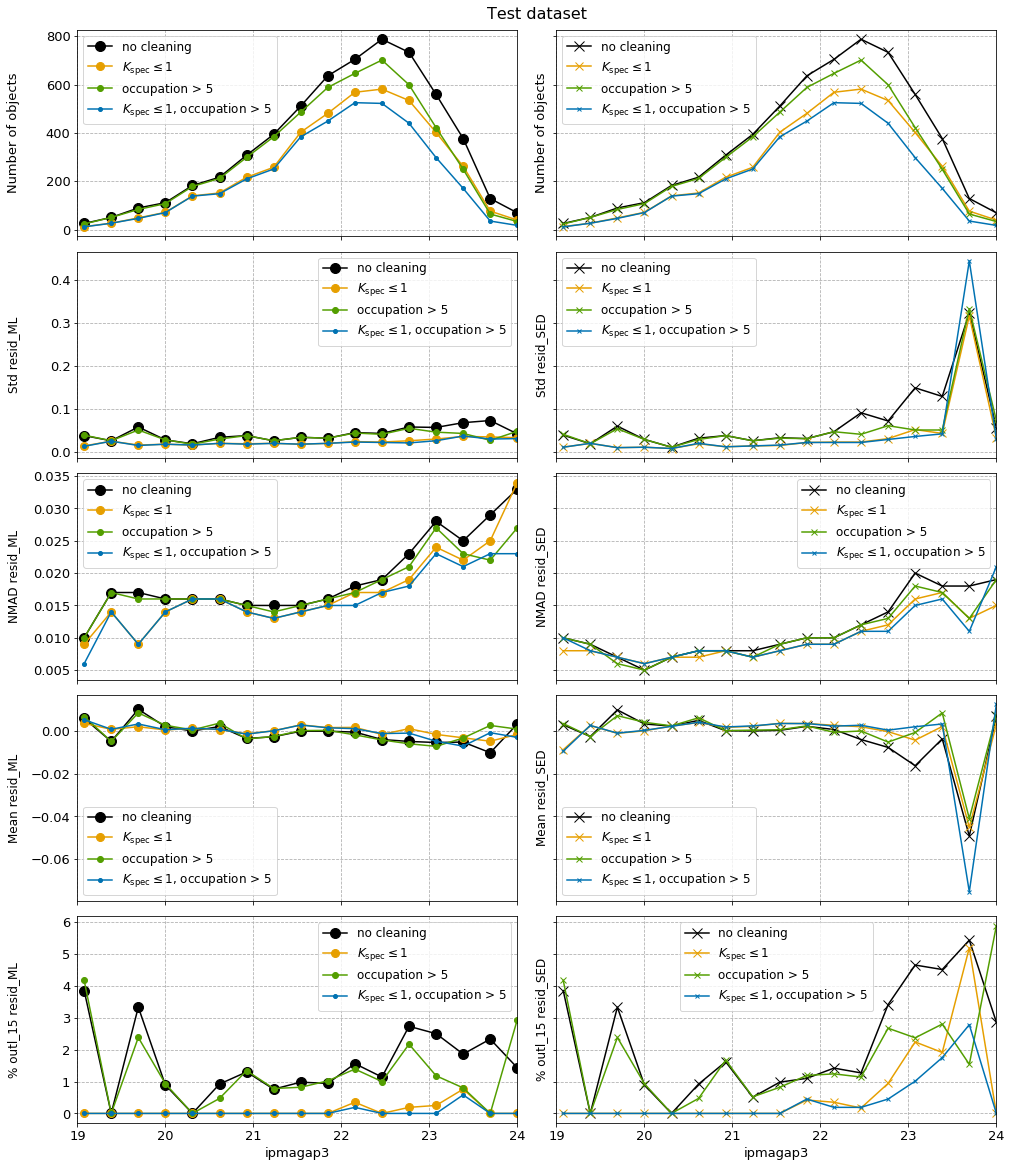

In [215]:
keyStat='Test'
stats=statAll[keyStat]
(r'$K_\mathrm{spec}$'+'\n'+ datasetNamesPlot[0]+' dataset')
estimators=['Std','NMAD','Mean','% outl_15']
cases=['magBins','magBins_specZ_filt','magBins_activMap','magBins_activMap_specZ']
labels=['no cleaning', r'$K_\mathrm{spec} \leq 1$', 'occupation > 5', r'$K_\mathrm{spec}\leq 1$'+ ', occupation > 5']
binCol='ipmagap3'
fig=plotBinnedStats(stats,estimators,residCols=[residML,residSED],cases=cases,binCol=binCol,xlim=(19,24),labels=labels)
fig.suptitle(keyStat+' dataset', fontsize=16, y=1.01, x=0.525)

Text(0.525, 1.01, 'Deimos dataset')

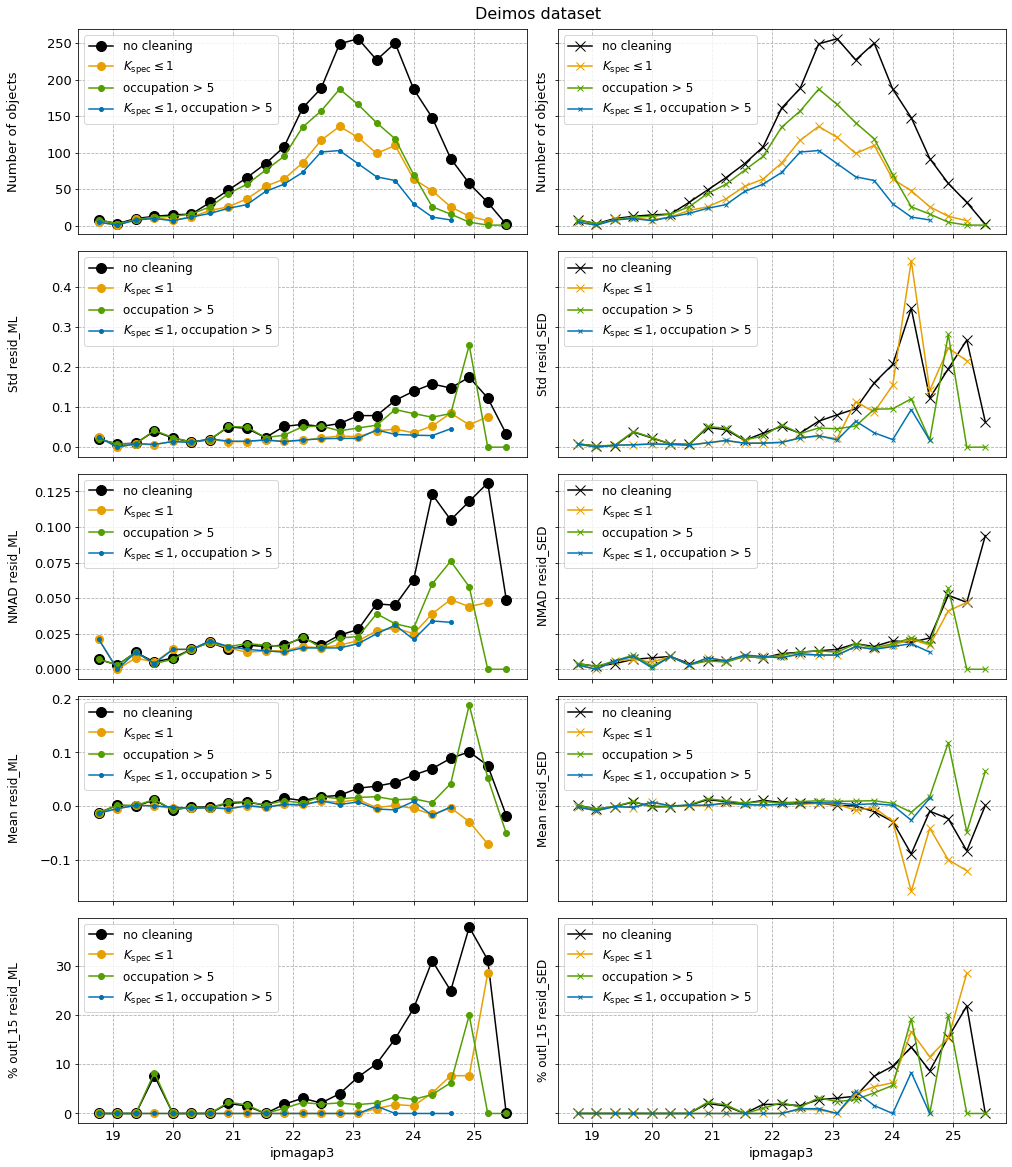

In [216]:
keyStat='Deimos'
stats=statAll[keyStat]

estimators=['Std','NMAD','Mean','% outl_15']
cases=['magBins','magBins_specZ_filt','magBins_activMap','magBins_activMap_specZ']
binCol='ipmagap3'
fig=plotBinnedStats(stats,estimators,residCols=[residML,residSED],cases=cases,binCol=binCol,labels=labels)
fig.suptitle(keyStat+' dataset', fontsize=16, y=1.01, x=0.525)

Text(0.56, 1.01, 'Run dataset')

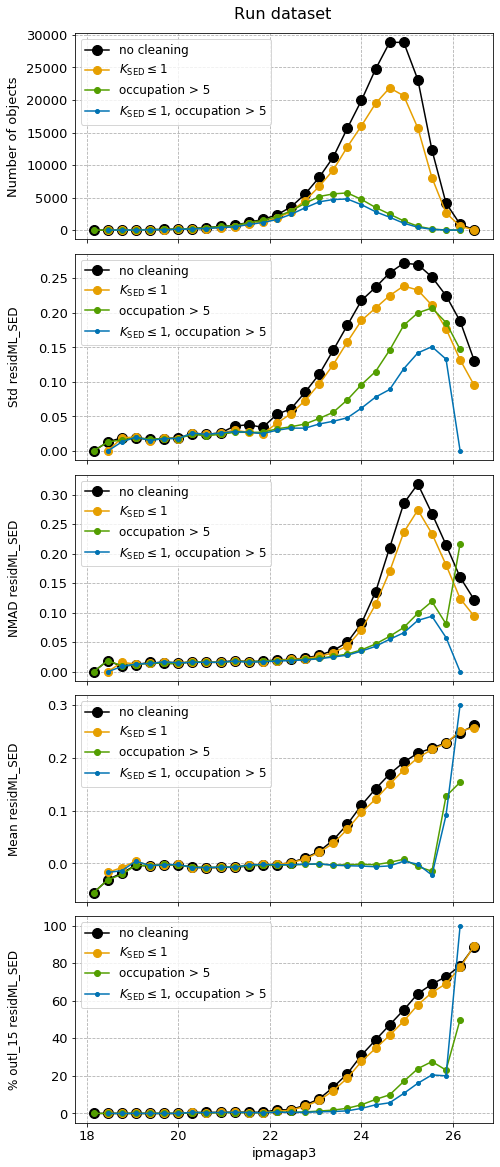

In [217]:
keyStat='Run'
stats=statAll[keyStat]

estimators=['Std','NMAD','Mean','% outl_15']
cases=['magBins','magBins_photoZ_SED_filt','magBins_activMap','magBins_activMap_photoZ_SED']
labels=['no cleaning', r'$K_\mathrm{SED} \leq 1$', 'occupation > 5', r'$K_\mathrm{SED} \leq 1$'+ ', occupation > 5']
binCol='ipmagap3'
fig=plotBinnedStats(stats,estimators,residCols=[residML_SED],cases=cases,binCol=binCol,labels=labels)
fig.suptitle(keyStat+' dataset', fontsize=16, y=1.01,x=0.56)

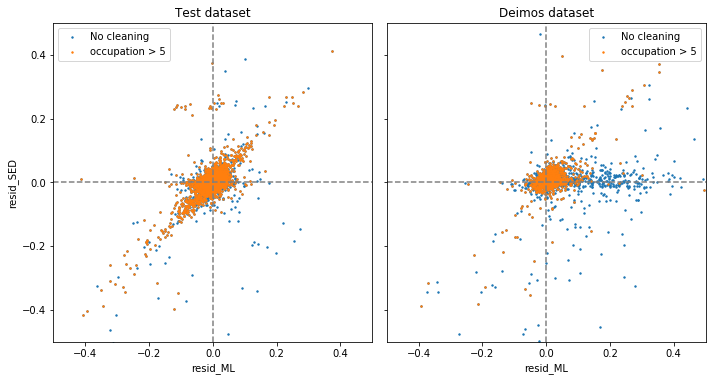

In [218]:
fig,axs=plt.subplots(1,2,figsize=(10,7),sharey=True)
names=['Test','Deimos']
for ax,name in zip(axs,names):
    ax.axvline(x=0,color='gray',linestyle='--')
    ax.axhline(y=0,color='gray',linestyle='--')
    data=datasets[name]
    ax.scatter(data['resid_ML'],data['resid_SED'],s=2,label='No cleaning')
    data=data[data['trainMapOccupation']>5]
    ax.scatter(data['resid_ML'],data['resid_SED'],s=2,label='occupation > 5')
    ax.set_xlim(-0.5,0.5)
    ax.set_ylim(-0.5,0.5)
    ax.set_xlabel('resid_ML')
    ax.set_aspect(1)
    ax.set_title(name+' dataset')
    ax.legend()
axs[0].set_ylabel('resid_SED')
plt.tight_layout()

### How spec-z distribution changes with filtering

In [137]:
def plotMultiBar(datasets,numBins,labels,alpha,logScale=False,normCounts=False,saveFlag=False,
                  range=None, saveName='',xlabel='',ylabel='',axs=None,grayscale=False,legendTextSize=None):
    if axs is None:
        axs = plt.gca()
        
    colorBlindPalette=['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']
    grayScalePalette=['#4c4c4c','#cccccc','#999999','#101010','#dedede']
    if grayscale==True:
        palette=grayScalePalette
    else:
        palette=colorBlindPalette 
    textSize=14
    if logScale==True:
        axs.set_yscale('log')
    if normCounts==True:
        weights=[]
        for data in datasets:
            weight = np.ones_like(data)/float(len(data))
            weights.append(weight)
        n, bins, patches = axs.hist(datasets, bins=numBins,weights=weights,color=palette[:len(datasets)],
                 alpha=alpha, label=labels,edgecolor='black', linewidth=1.2, range=range)
    else:
        n, bins, patches = axs.hist(datasets,bins=numBins,color=palette[:len(datasets)],
                 alpha=alpha,label=labels,edgecolor='black', linewidth=1.2, range=range)  
    if grayscale==True:
        hatches = ['..', 'xx', '**','','|||']
        for patch_set, hatch in zip(patches, hatches):
            plt.setp(patch_set, hatch=hatch)
    axs.set_xlabel(xlabel,size=textSize)
    axs.set_ylabel(ylabel,size=textSize)
    if legendTextSize:
        axs.legend(prop={'size': legendTextSize})
    else:
        axs.legend()

    if saveFlag==True:
        if saveName=="":
            print("Cannot save catalog: saveName is empty string")
        else:
            plt.savefig(saveName)
    return

In [153]:
data=datasets['Test']
d=data[data['specZ_outlCoeff'].abs()<=1]
d=d[d['trainMapOccupation']>5]

Text(0.5, 1.03, 'Test dataset')

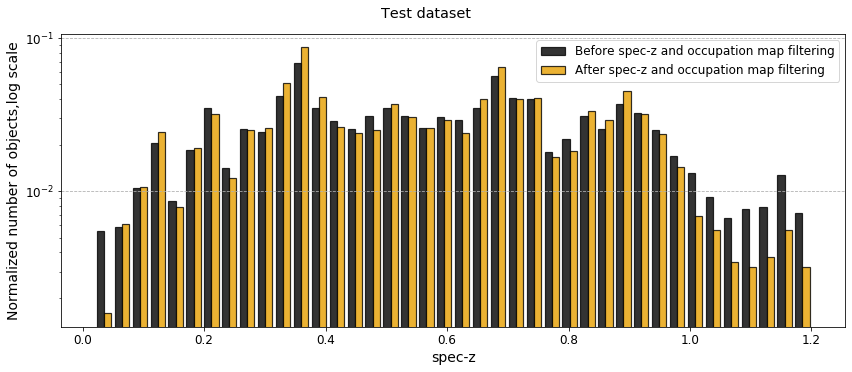

In [154]:
datasetsWork=[data['specZ'],d['specZ']]
labels=['Before spec-z and occupation map filtering','After spec-z and occupation map filtering']
numBins=40
plt.rcParams.update({'font.size': 12})
fig, axs1 = plt.subplots(1, 1,figsize=(12,5))
axs1.grid(axis='y',linestyle ='--')
#axs2.grid(axis='y',linestyle ='--')
plotMultiBar(datasetsWork,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='spec-z',ylabel='Normalized number of objects,log scale',axs=axs1,grayscale=False)
#plotMultiBar(datasetsWork,numBins,labels,logScale=False,alpha=0.8,normCounts=False,
#              xlabel='spectr-z',ylabel='Number of objects',axs=axs2,grayscale=False)
plt.tight_layout()
fig.suptitle('Test dataset',y=1.03)

In [155]:
data=datasets['Deimos']
d=data[data['specZ_outlCoeff'].abs()<=1]
d=d[d['trainMapOccupation']>5]

Text(0.5, 1.03, 'DEIMOS dataset')

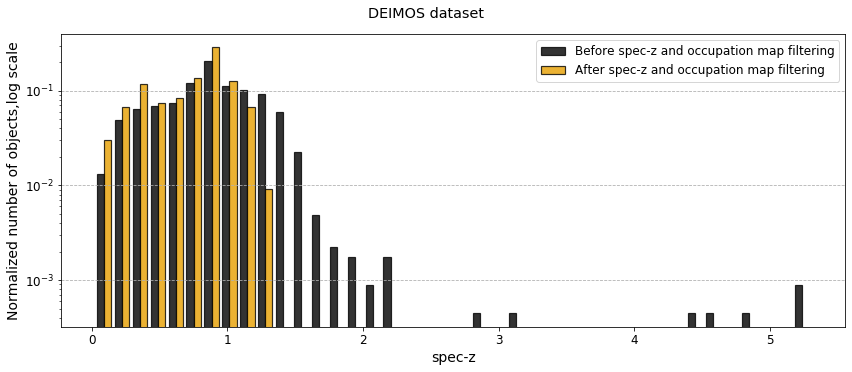

In [156]:
datasetsWork=[data['specZ'],d['specZ']]
labels=['Before spec-z and occupation map filtering','After spec-z and occupation map filtering']
numBins=40
plt.rcParams.update({'font.size': 12})
fig, axs1 = plt.subplots(1, 1,figsize=(12,5))
axs1.grid(axis='y',linestyle ='--')
#axs2.grid(axis='y',linestyle ='--')
plotMultiBar(datasetsWork,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='spec-z',ylabel='Normalized number of objects,log scale',axs=axs1,grayscale=False)
#plotMultiBar(datasetsWork,numBins,labels,logScale=False,alpha=0.8,normCounts=False,
#              xlabel='spectr-z',ylabel='Number of objects',axs=axs2,grayscale=False)
plt.tight_layout()
fig.suptitle('DEIMOS dataset',y=1.03)

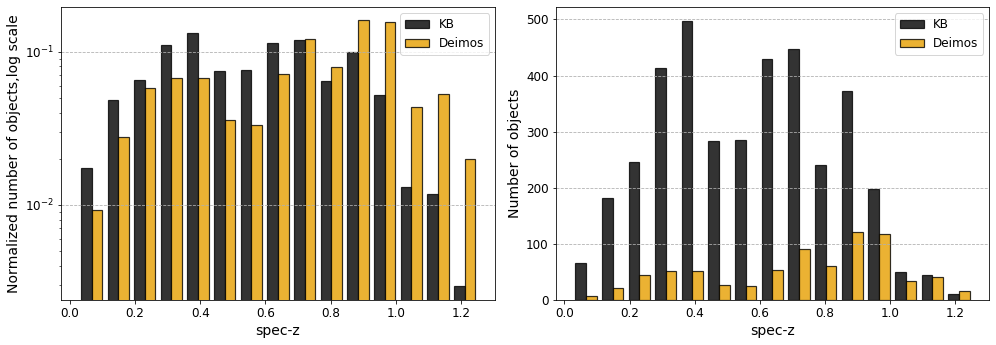

In [163]:
data=datasets['Test']
dTest=data[data['specZ_outlCoeff'].abs()<=1]
dTest=dTest[dTest['trainMapOccupation']>5]

data=datasets['Deimos']
dDeimos=data[data['specZ_outlCoeff'].abs()<=1]
dDeimos=dDeimos[dDeimos['trainMapOccupation']>5]

datasetsWork=[dTest['specZ'],dDeimos['specZ']]
labels=['KB','Deimos']
numBins=15
fig, (axs1,axs2) = plt.subplots(1, 2,figsize=(14,5))
axs1.grid(axis='y',linestyle ='--')
axs2.grid(axis='y',linestyle ='--')
plotMultiBar(datasetsWork,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='spec-z',ylabel='Normalized number of objects,log scale',axs=axs1,grayscale=False)
plotMultiBar(datasetsWork,numBins,labels,logScale=False,alpha=0.8,normCounts=False,
              xlabel='spec-z',ylabel='Number of objects',axs=axs2,grayscale=False)
plt.tight_layout()

### Comparing spec-z distribution of the default and 'dirty SOM-cleaned' datasets

In [144]:
testDirty=pd.read_csv(join(r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\experimentsArticle\DirtySample\exp027',
                                  'METAPHOR_testout_05_COSMOS_SpectrZ_Zlim_1p2_specZOutlCoeff_filter.csv'))

In [165]:
data=datasets['Test']
d=data[data['specZ_outlCoeff'].abs()<=1]
d=d[d['trainMapOccupation']>5]

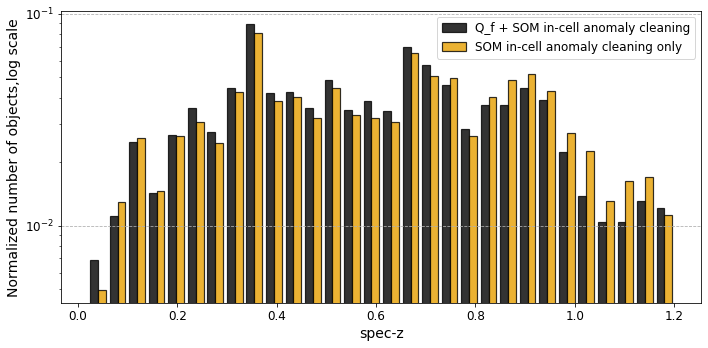

In [169]:
datasetsWork=[data['specZ'],testDirty['z_spec']]
labels=['Q_f + SOM in-cell anomaly cleaning','SOM in-cell anomaly cleaning only']
numBins=30
plt.rcParams.update({'font.size': 12})
fig, axs1 = plt.subplots(1, 1,figsize=(10,5))
axs1.grid(axis='y',linestyle ='--')
#axs2.grid(axis='y',linestyle ='--')
plotMultiBar(datasetsWork,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='spec-z',ylabel='Normalized number of objects,log scale',axs=axs1,grayscale=False)
#plotMultiBar(datasetsWork,numBins,labels,logScale=False,alpha=0.8,normCounts=False,
#              xlabel='spec-z',ylabel='Number of objects',axs=axs2,grayscale=False)
plt.tight_layout()
#fig.suptitle('',y=1.03)